# ACA-O Sri Lanka – Multi-Dataset Analysis & PyTorch Baselines

This notebook is a starting point for your **Adaptive Crop & Area Optimization (ACA-O)** project.

It uses **multiple Sri Lankan datasets from Kaggle** plus optional local CSV files to:
- Download & explore crop, price, economy, and climate datasets (paddy + vegetables).
- Train **PyTorch** models for:
  - Rice production from economic indicators (tabular MLP).
  - Vegetable price forecasting (time-series LSTM).
- Provide reusable analysis blocks so you can easily modify and extend later.

You can run each section step-by-step and adjust column names or model settings as needed.

## 1. Setup and imports

Run this cell first.

In [45]:
import os
from pathlib import Path
import zipfile
import glob
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

plt.style.use('default')
sns.set_theme(style='whitegrid')

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)
print('Torch version:', torch.__version__)

Using device: cuda
Torch version: 2.7.1+cu118


## 2. Kaggle download helper

This section defines a helper function to **auto-download Kaggle datasets** the first time you run the notebook.

### One-time Kaggle setup (outside the notebook)
1. Create a Kaggle account and go to **Account → API → Create New Token**.
2. Download `kaggle.json`.
3. On your machine, put it in `~/.kaggle/kaggle.json` (Linux/macOS) or `C:\\Users\\<you>\\.kaggle\\kaggle.json` (Windows).
   - Or, you can manually set `KAGGLE_USERNAME` and `KAGGLE_KEY` environment variables.

Once that's done, the function below will work.

In [46]:
DATA_ROOT = Path('data')
DATA_ROOT.mkdir(exist_ok=True)

def ensure_kaggle():
    """Install kaggle package if needed."""
    try:
        import kaggle  # noqa: F401
    except ImportError:
        print('Installing kaggle package...')
        %pip install -q kaggle
        import kaggle  # noqa: F401

def unzip_all_in_folder(folder: Path):
    """Unzip all .zip files in a folder and remove the zip files."""
    zip_files = list(folder.glob('*.zip'))
    for zip_path in zip_files:
        print(f'[Unzip] Extracting {zip_path.name}...')
        with zipfile.ZipFile(zip_path, 'r') as z:
            z.extractall(folder)
        zip_path.unlink()
        print(f'[Unzip] Done: {zip_path.name}')

def download_kaggle_dataset(slug: str, dest_dir: Path):
    """Download & unzip a Kaggle dataset (if not already present).

    slug: 'owner/dataset-name', e.g. 'namalrathnayake1990/economy-and-rice-production-sri-lanka-1960-2020'
    dest_dir: local folder to store the dataset
    """
    dest_dir.mkdir(parents=True, exist_ok=True)
    
    # If there are already CSV files, assume it's downloaded
    existing = list(dest_dir.glob('*.csv'))
    if existing:
        print(f"[Kaggle] Found {len(existing)} CSV files in {dest_dir}, skipping download.")
        return
    
    # Check if there are zip files that need to be extracted
    zip_files = list(dest_dir.glob('*.zip'))
    if zip_files:
        print(f"[Kaggle] Found {len(zip_files)} zip files, extracting...")
        unzip_all_in_folder(dest_dir)
        return

    ensure_kaggle()
    from kaggle.api.kaggle_api_extended import KaggleApi
    
    try:
        api = KaggleApi()
        api.authenticate()
        
        print(f'[Kaggle] Downloading {slug} to {dest_dir} ...')
        api.dataset_download_files(slug, path=str(dest_dir), unzip=True)
        
        # Double-check for any remaining zip files and extract them
        unzip_all_in_folder(dest_dir)
        
        print('[Kaggle] Done. Files in folder:')
        for p in dest_dir.glob('*'):
            print(' -', p.name)
    except Exception as e:
        print(f'[Kaggle] Error downloading {slug}: {e}')
        print('\n⚠️ Make sure you have set up Kaggle credentials:')
        print('   1. Go to https://www.kaggle.com/settings → API → Create New Token')
        print('   2. Save kaggle.json to C:\\Users\\<username>\\.kaggle\\kaggle.json')
        raise

## 3. Configure Kaggle datasets

These are the datasets you listed. The slugs are taken from Kaggle:

- **Paddy Cultivation Statistics in Sri Lanka** – `tharindumadhusanka9/paddy-cultivation-statics-in-sri-lanka`
- **Economy and Rice Production Sri Lanka (1960–2020)** – `namalrathnayake1990/economy-and-rice-production-sri-lanka-1960-2020`
- **Vegetable Price Forecasting** – `nisith210144g/vegi-price`
- **Historical Vegetable and Fruit Prices in Sri Lanka** (with climate effect) – `isuranga/historical-vegetable-and-fruit-prices-in-sri-lanka`
- **Sri Lanka Rice Time Series Data (SriOryzia)** – `luqmanrumaiz/srioryzia-multivariate-rice-price-forecasting`
- **Sri Lanka Climate / Meteorology Dataset** – here we use `tharindumadhusanka9/sri-lanka-climate-data`

You can comment out any dataset you don't want to download right now.

In [47]:
kaggle_datasets = {
    'paddy_stats': {
        'slug': 'tharindumadhusanka9/paddy-cultivation-statics-in-sri-lanka',
        'dir': DATA_ROOT / 'paddy_stats',
    },
    'economy_rice': {
        'slug': 'namalrathnayake1990/economy-and-rice-production-sri-lanka-1960-2020',
        'dir': DATA_ROOT / 'economy_rice',
    },
    'veg_price_forecast': {
        'slug': 'nisith210144g/vegi-price',
        'dir': DATA_ROOT / 'veg_price_forecast',
    },
    'hist_veg_fruit_prices': {
        'slug': 'isuranga/historical-vegetable-and-fruit-prices-in-sri-lanka',
        'dir': DATA_ROOT / 'hist_veg_fruit_prices',
    },
    'srioryzia_rice_ts': {
        'slug': 'luqmanrumaiz/srioryzia-multivariate-rice-price-forecasting',
        'dir': DATA_ROOT / 'srioryzia_rice_ts',
    },
    'climate_data': {
        'slug': 'tharindumadhusanka9/sri-lanka-climate-data',
        'dir': DATA_ROOT / 'climate_data',
    },
}

# Download all configured datasets (you can comment out some keys if needed)
for key, cfg in kaggle_datasets.items():
    print(f"\n=== {key} ===")
    download_kaggle_dataset(cfg['slug'], cfg['dir'])


=== paddy_stats ===
[Kaggle] Found 38 CSV files in data\paddy_stats, skipping download.

=== economy_rice ===
[Kaggle] Found 1 CSV files in data\economy_rice, skipping download.

=== veg_price_forecast ===
[Kaggle] Found 7 CSV files in data\veg_price_forecast, skipping download.

=== hist_veg_fruit_prices ===
[Kaggle] Found 1 CSV files in data\hist_veg_fruit_prices, skipping download.

=== srioryzia_rice_ts ===
[Kaggle] Downloading luqmanrumaiz/srioryzia-multivariate-rice-price-forecasting to data\srioryzia_rice_ts ...
Dataset URL: https://www.kaggle.com/datasets/luqmanrumaiz/srioryzia-multivariate-rice-price-forecasting
[Kaggle] Done. Files in folder:
 - final
 - processed
 - raw

=== climate_data ===
[Kaggle] Found 1 CSV files in data\climate_data, skipping download.
[Kaggle] Done. Files in folder:
 - final
 - processed
 - raw

=== climate_data ===
[Kaggle] Found 1 CSV files in data\climate_data, skipping download.


## 4. Helper: load the main CSV from a folder

Each Kaggle dataset may contain several CSV files. This helper picks the **largest CSV**
(by file size) as the main one, which usually works well. You can change it later if needed.

In [48]:
def load_main_csv(folder: Path) -> pd.DataFrame:
    # First try direct CSV files in folder
    csv_files = list(folder.glob('*.csv'))
    
    # If no CSVs found, search recursively
    if not csv_files:
        csv_files = list(folder.rglob('*.csv'))
    
    if not csv_files:
        raise FileNotFoundError(f'No CSV files found in {folder}')
    
    # choose largest file
    csv_files.sort(key=lambda p: p.stat().st_size, reverse=True)
    main_csv = csv_files[0]
    print(f'Using main CSV: {main_csv.relative_to(folder)}')
    
    # Try different encodings
    encodings = ['utf-8', 'latin-1', 'cp1252', 'iso-8859-1']
    for encoding in encodings:
        try:
            df = pd.read_csv(main_csv, encoding=encoding, low_memory=False)
            print(f'  → Loaded with encoding: {encoding}')
            return df
        except UnicodeDecodeError:
            continue
    
    # Fallback: read with errors='replace'
    print(f'  → Using fallback encoding with error replacement')
    df = pd.read_csv(main_csv, encoding='utf-8', errors='replace', low_memory=False)
    return df

# Load dataframes
df_paddy = load_main_csv(kaggle_datasets['paddy_stats']['dir'])
df_economy = load_main_csv(kaggle_datasets['economy_rice']['dir'])
df_veg_price = load_main_csv(kaggle_datasets['veg_price_forecast']['dir'])
df_hist_veg = load_main_csv(kaggle_datasets['hist_veg_fruit_prices']['dir'])
df_rice_ts = load_main_csv(kaggle_datasets['srioryzia_rice_ts']['dir'])
df_climate = load_main_csv(kaggle_datasets['climate_data']['dir'])

Using main CSV: 2012-2013 Maha.csv
  → Loaded with encoding: utf-8
Using main CSV: Economy vs Rice production in Sri Lanka.csv
  → Loaded with encoding: utf-8
Using main CSV: ReddishCleanedwithDollar.csv
  → Loaded with encoding: utf-8
Using main CSV: Vegetables_fruit_prices_with_climate_130000_2020_to_2025.csv
  → Loaded with encoding: latin-1
Using main CSV: processed\processed_data.csv
  → Loaded with encoding: utf-8
Using main CSV: Sri_Lanka_Climate_Data.csv
  → Loaded with encoding: utf-8
  → Loaded with encoding: utf-8
Using main CSV: Sri_Lanka_Climate_Data.csv
  → Loaded with encoding: utf-8


## 5. Quick overview (EDA) for each dataset

We look at basic info: shape, columns, and first few rows.

In [49]:
def quick_eda(df: pd.DataFrame, name: str, n_head: int = 5):
    print(f'\n===== {name} =====')
    print('Shape:', df.shape)
    print('Columns:', list(df.columns))
    display(df.head(n_head))
    display(df.describe(include='all').T)

quick_eda(df_paddy, 'Paddy cultivation stats')
quick_eda(df_economy, 'Economy & rice production (1960-2020)')
quick_eda(df_veg_price, 'Vegetable price forecasting dataset')
quick_eda(df_hist_veg, 'Historical vegetable & fruit prices (with climate)')
quick_eda(df_rice_ts, 'Sri Lanka rice time series (SriOryzia)')
quick_eda(df_climate, 'Sri Lanka climate / meteorology dataset')


===== Paddy cultivation stats =====
Shape: (28, 15)
Columns: ['District', 'Major_Schemes_Sown', 'Minor_Schemes_Sown', 'Rainfed_Sown', 'All_Schemes_Sown', 'Major_Schemes_Harvested', 'Minor_Schemes_Harvested', 'Rainfed_Harvested', 'All_Schemes_Harvested', 'Major_Schemes_Yield', 'Minor_Schemes_Yield', 'Rainfed_Yield', 'Average_Yield', 'Nett_Extent_Harvested', 'Total_Production']


,District,Major_Schemes_Sown,Minor_Schemes_Sown,Rainfed_Sown,All_Schemes_Sown,Major_Schemes_Harvested,Minor_Schemes_Harvested,Rainfed_Harvested,All_Schemes_Harvested,Major_Schemes_Yield,Minor_Schemes_Yield,Rainfed_Yield,Average_Yield,Nett_Extent_Harvested,Total_Production
0,COLOMBO,87,973,3002,4062,87,973,3002,4062,3508,3692,3568,3597,3453,12418
1,GAMPAHA,1758,3388,6030,11176,1758,3380,6015,11153,3959,3955,3573,3750,9480,35547
2,KALUTARA,93,2321,11224,13638,93,2310,11179,13582,3250,3249,3073,3105,12529,38898
3,KANDY,4089,5462,2441,11992,4089,5426,2430,11944,4845,3709,3295,4013,9446,37909
4,MATALE,6948,9036,5184,21168,6908,8940,5160,21008,5179,4296,3556,4404,18892,83208


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
District,28,28,COLOMBO,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Major_Schemes_Sown,28,27,-,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Minor_Schemes_Sown,28,26,-,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rainfed_Sown,28,27,-,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
All_Schemes_Sown,28.0,NaN,NaN,NaN,55688.214286,144249.518786,4062.0,12509.0,19192.0,35448.75,779635.0
Major_Schemes_Harvested,28,27,-,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Minor_Schemes_Harvested,28,26,-,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rainfed_Harvested,28,27,-,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
All_Schemes_Harvested,28.0,NaN,NaN,NaN,52970.785714,137301.751033,4062.0,11809.75,16313.5,32512.75,741591.0
Major_Schemes_Yield,28,27,-,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN



===== Economy & rice production (1960-2020) =====
Shape: (61, 10)
Columns: ['Year', 'GDP ($B) ', 'Inflation (%)', 'Manufacturing ($B)', 'Population ', 'Growth Rate (%)', 'Imports ($B)', 'Arable Land', 'Military($B)', 'Rice Production (Mt.)']


,Year,GDP ($B),Inflation (%),Manufacturing ($B),Population,Growth Rate (%),Imports ($B),Arable Land,Military($B),Rice Production (Mt.)
0,1960.0,1.41,-0.02,0.23,9783871.0,0.02,0.46,595000.0,0.02,899.0
1,1961.0,1.44,0.01,0.23,10022888.0,0.02,0.41,595000.0,0.02,900.0
2,1962.0,1.43,0.02,0.24,10267067.0,0.02,0.42,577000.0,0.02,1003.0
3,1963.0,1.24,0.02,0.20,10517531.0,0.02,0.34,792000.0,0.01,1028.0
4,1964.0,1.31,0.03,0.21,10774086.0,0.02,0.35,790000.0,0.01,1056.0


,count,mean,std,min,25%,50%,75%,max
Year,61.0,1.990000e+03,1.775293e+01,1960.00,1975.00,1990.00,2005.00,2020.00
GDP ($B),61.0,2.253590e+01,2.947132e+01,1.24,3.36,8.03,24.41,94.49
Inflation (%),61.0,8.180328e-02,5.855220e-02,-0.02,0.04,0.08,0.12,0.26
Manufacturing ($B),61.0,3.769180e+00,4.951955e+00,0.20,0.61,1.08,4.76,14.39
Population,61.0,1.663657e+07,3.635156e+06,9783871.00,13662873.00,17204094.00,19673866.00,21715079.00
Growth Rate (%),61.0,1.278689e-02,6.359022e-03,0.00,0.01,0.01,0.02,0.02
Imports ($B),61.0,6.863279e+00,7.638035e+00,0.34,1.13,3.06,10.07,26.80
Arable Land,61.0,9.578914e+05,1.989408e+05,577000.00,850000.00,900000.00,1000000.00,1372000.00
Military($B),61.0,5.840984e-01,6.557550e-01,0.01,0.03,0.28,0.82,2.06
Rice Production (Mt.),61.0,2.310672e+03,8.835292e+02,758.00,1605.00,2389.00,2860.00,4301.00



===== Vegetable price forecasting dataset =====
Shape: (847, 14)
Columns: ['Date', 'Item', 'Pettah', 'Kandy', 'Dambulla', 'Meegoda', 'Norochchole', 'Thambuththegama', 'Keppetipola', 'Nuwara Eliya', 'Bandarawela', 'Nuwaraeliya', 'Peliyagoda', 'Veyangoda']


,Date,Item,Pettah,Kandy,Dambulla,Meegoda,Norochchole,Thambuththegama,Keppetipola,Nuwara Eliya,Bandarawela,Nuwaraeliya,Peliyagoda,Veyangoda
0,2020-01-01,Raddish,80.00--100.00,NaN,70.00--80.00,95.00--100.00,50.00--60.00,80.00--100.00,NaN,80.00-90.00,NaN,NaN,NaN,NaN
1,2020-01-07,Raddish,40.00--60.00,40.00--50.00,30.00--35.00,60.00--70.00,20.00--40.00,45.00--55.00,30.00-40.00,50.00-55.00,NaN,NaN,NaN,NaN
2,2020-01-10,Raddish,60.00--80.00,50.00--60.00,40.00--50.00,NaN,NaN,50.00--70.00,NaN,55.00-60.00,NaN,NaN,NaN,NaN
3,2020-01-12,Raddish,NaN,50.00--60.00,40.00--45.00,70.00--80.00,NaN,40.00--60.00,28.00-30.00,45.00-50.00,NaN,NaN,NaN,NaN
4,2020-01-13,Raddish,80.00--100.00,70.00--80.00,50.00-60.00,90.00-100.00,50.00-70.00,80.00-100.00,NaN,65.00-70.00,NaN,NaN,NaN,NaN


,count,unique,top,freq
Date,847,847,2023-12-29,1
Item,847,1,Raddish,847
Pettah,347,45,60.00--80.00,45
Kandy,843,77,40.00--50.00,82
Dambulla,838,128,30--40,44
Meegoda,772,117,70.00--80.00,54
Norochchole,681,107,50--60,45
Thambuththegama,832,144,50.00--70.00,52
Keppetipola,745,110,40--50,56
Nuwara Eliya,178,18,45.00-50.00,36



===== Historical vegetable & fruit prices (with climate) =====
Shape: (130000, 10)
Columns: ['Date', 'Region', 'Temperature (°C)', 'Rainfall (mm)', 'Humidity (%)', 'Crop Yield Impact Score', 'fruit_Commodity', 'fruit_Price per Unit (LKR/kg)', 'vegitable_Commodity', 'vegitable_Price per Unit (LKR/kg)']


,Date,Region,Temperature (°C),Rainfall (mm),Humidity (%),Crop Yield Impact Score,fruit_Commodity,fruit_Price per Unit (LKR/kg),vegitable_Commodity,vegitable_Price per Unit (LKR/kg)
0,1/1/2020,Ampara,34.4,384.0,69.3,1.67,Banana,282.26,Winged Bean,376.43
1,1/1/2020,Anuradhapura,33.0,21.7,63.5,1.64,Banana,230.28,Winged Bean,210.15
2,1/1/2020,Badulla,35.7,121.8,73.5,1.73,Banana,317.02,Winged Bean,362.29
3,1/1/2020,Batticaloa,30.5,243.7,52.7,1.62,Banana,125.04,Winged Bean,169.92
4,1/1/2020,Colombo,35.4,3.2,93.1,0.54,Banana,117.30,Winged Bean,372.34


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Date,130000,1828,12/28/2020,72,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Region,130000,25,Ampara,5200,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Temperature (°C),130000.0,NaN,NaN,NaN,29.171526,5.07841,20.0,24.7,29.4,33.7,38.0
Rainfall (mm),130000.0,NaN,NaN,NaN,181.935109,116.312786,0.4,74.3,172.0,277.4,399.0
Humidity (%),130000.0,NaN,NaN,NaN,72.981717,12.751335,50.1,61.6,74.2,83.8,95.0
Crop Yield Impact Score,130000,150,0.6,1938,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fruit_Commodity,130000,17,Banana,7925,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fruit_Price per Unit (LKR/kg),130000.0,NaN,NaN,NaN,275.57655,130.338096,50.02,161.55,278.5,387.34,499.99
vegitable_Commodity,130000,20,Winged Bean,6500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vegitable_Price per Unit (LKR/kg),130000.0,NaN,NaN,NaN,274.554938,129.637557,50.01,160.93,274.73,385.65,499.97



===== Sri Lanka rice time series (SriOryzia) =====
Shape: (324, 13)
Columns: ['date', 'price', 'anuradhapura_producer_price', 'kurunegala_producer_price', 'polonnaruwa_producer_price', 'production', 'production_total', 'exchange_rate', 'fuel_price', 'm0', 'm2', 'm1', 'm2b']


,date,price,anuradhapura_producer_price,kurunegala_producer_price,polonnaruwa_producer_price,production,production_total,exchange_rate,fuel_price,m0,m2,m1,m2b
0,1996-01-01,18.07,7.75,7.90,8.18,1333.6,2065.1,53.685,12.4,77071,228090,73783,260481
1,1996-02-01,18.70,8.17,8.26,8.76,1333.6,2065.1,53.685,12.4,79586,234199,77440,269496
2,1996-03-01,18.49,7.95,7.85,7.99,1333.6,2065.1,53.685,12.4,82915,239178,81796,272552
3,1996-04-01,18.52,8.25,8.01,8.29,1333.6,2065.1,54.735,12.4,80873,241893,79478,278425
4,1996-05-01,19.02,8.38,8.50,8.34,731.5,2065.1,54.950,12.4,83410,242072,76620,277365


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
date,324,324,2022-12-01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,320.0,NaN,NaN,NaN,61.460844,41.523549,18.07,28.7875,59.94,78.655,250.07
anuradhapura_producer_price,312.0,NaN,NaN,NaN,27.760449,21.046822,7.75,12.195,25.46,35.1675,131.55
kurunegala_producer_price,314.0,NaN,NaN,NaN,28.377529,21.493946,7.81,12.08,26.545,35.5725,141.95
polonnaruwa_producer_price,304.0,NaN,NaN,NaN,28.570263,22.532763,7.87,12.36,25.705,35.8925,138.2
production,324.0,NaN,NaN,NaN,1831.638627,636.826804,731.5,1333.6,1774.5,2135.6,3196.75
production_total,324.0,NaN,NaN,NaN,3521.530556,867.00639,2065.1,2858.8,3380.8,4300.6,5149.6
exchange_rate,324.0,NaN,NaN,NaN,124.16716,55.706235,53.685,96.1875,111.15,144.895,368.5
fuel_price,324.0,NaN,NaN,NaN,77.366358,69.05294,12.4,30.0,73.0,104.0,460.0
m0,324.0,NaN,NaN,NaN,444192.376543,372493.241994,71828.0,121346.0,280208.0,743791.75,1481805.0



===== Sri Lanka climate / meteorology dataset =====
Shape: (314028, 6)
Columns: ['date', 'latitude', 'longitude', 'temperature_2m_max', 'temperature_2m_min', 'precipitation_sum']


,date,latitude,longitude,temperature_2m_max,temperature_2m_min,precipitation_sum
0,2022-11-11 00:00:00+00:00,6.066667,80.231034,28.7975,24.4975,1.000000
1,2022-11-12 00:00:00+00:00,6.066667,80.231034,27.7475,23.2975,17.800001
2,2022-11-13 00:00:00+00:00,6.066667,80.231034,26.6475,23.2475,13.599999
3,2022-11-14 00:00:00+00:00,6.066667,80.231034,28.1475,22.8975,17.900002
4,2022-11-15 00:00:00+00:00,6.066667,80.231034,28.3475,22.6475,23.499998


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
date,314028,732,2024-11-11 00:00:00+00:00,429,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,314028.0,NaN,NaN,NaN,7.642036,0.920018,6.066667,6.9,7.566667,8.4,9.733333
longitude,314028.0,NaN,NaN,NaN,80.697701,0.511793,79.775862,80.306897,80.686207,81.065517,81.824138
temperature_2m_max,314028.0,NaN,NaN,NaN,30.763622,3.324311,14.7095,28.7975,30.558,33.0195,41.164997
temperature_2m_min,314028.0,NaN,NaN,NaN,23.154171,2.406658,6.7595,22.149,23.3915,24.7175,30.3195
precipitation_sum,314028.0,NaN,NaN,NaN,5.907706,9.548971,0.0,0.3,1.9,7.5,186.1


### 5.1 Optional: local CSV files you uploaded

If you have local CSVs like weather or paddy production (for example from data.gov.lk),
you can inspect them here. This code is safe even if the files don't exist.

In [50]:
local_files = [
    'sample_101_SriLanka_Weather_Dataset_V1.csv',
    'total_paddy_production_in_1952_2012.csv',
    'production_of_major_agricultural_crops.csv',
    'paddy_production_in_yala_season_1952_2012.csv',
    'paddy_production_in_maha_season_1952-2012.csv',
]

for fname in local_files:
    path = Path(fname)
    if path.exists():
        print(f"\n--- {fname} ---")
        df_local = pd.read_csv(path)
        quick_eda(df_local, fname)
    else:
        print(f"\n[info] Local file not found (skip): {fname}")


[info] Local file not found (skip): sample_101_SriLanka_Weather_Dataset_V1.csv

[info] Local file not found (skip): total_paddy_production_in_1952_2012.csv

[info] Local file not found (skip): production_of_major_agricultural_crops.csv

[info] Local file not found (skip): paddy_production_in_yala_season_1952_2012.csv

[info] Local file not found (skip): paddy_production_in_maha_season_1952-2012.csv


## 6. Deeper EDA: Economy & Rice Production (1960–2020)

We start with the **Economy and Rice Production** dataset and visualise some basic patterns.
You may need to adjust column names here to match your CSV.

In [51]:
# === Configure these according to df_economy ===
# Try printing df_economy.columns above and set the right names.
ECON_YEAR_COL = 'Year'              # example
ECON_TARGET_COL = 'Rice_production' # example name, edit to match your file

print('Economy columns:', df_economy.columns.tolist())
if ECON_YEAR_COL in df_economy.columns and ECON_TARGET_COL in df_economy.columns:
    econ_plot_df = df_economy[[ECON_YEAR_COL, ECON_TARGET_COL]].dropna()
    econ_plot_df = econ_plot_df.sort_values(ECON_YEAR_COL)

    plt.figure(figsize=(8,4))
    plt.plot(econ_plot_df[ECON_YEAR_COL], econ_plot_df[ECON_TARGET_COL])
    plt.xlabel('Year')
    plt.ylabel(ECON_TARGET_COL)
    plt.title('Rice production over time')
    plt.tight_layout()
    plt.show()
else:
    print('⚠️ Please update ECON_YEAR_COL and ECON_TARGET_COL to match your CSV.')

Economy columns: ['Year', 'GDP ($B) ', 'Inflation (%)', 'Manufacturing ($B)', 'Population ', 'Growth Rate (%)', 'Imports ($B)', 'Arable Land', 'Military($B)', 'Rice Production (Mt.)']
⚠️ Please update ECON_YEAR_COL and ECON_TARGET_COL to match your CSV.


## 7. PyTorch MLP: Predict rice production from economic indicators

Here we build a **feed-forward neural network (MLP)** using PyTorch to predict rice production.
We also compare it with a simple **Linear Regression** baseline.

⚠️ You must set `ECON_TARGET_COL` correctly and choose which feature columns to use.

In [52]:
# === Configure feature columns for the economy dataset ===
# Example: all numeric columns except Year + target
numeric_cols = df_economy.select_dtypes(include=[np.number]).columns.tolist()
print('Numeric columns:', numeric_cols)

if ECON_TARGET_COL in numeric_cols:
    ECON_FEATURE_COLS = [c for c in numeric_cols if c != ECON_TARGET_COL]
    print('Using features:', ECON_FEATURE_COLS)

    econ_df_model = df_economy.dropna(subset=[ECON_TARGET_COL] + ECON_FEATURE_COLS).copy()
    X = econ_df_model[ECON_FEATURE_COLS].values.astype(np.float32)
    y = econ_df_model[ECON_TARGET_COL].values.astype(np.float32).reshape(-1, 1)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    x_scaler = StandardScaler()
    X_train_scaled = x_scaler.fit_transform(X_train)
    X_test_scaled = x_scaler.transform(X_test)

    # Baseline: Linear Regression
    lin_reg = LinearRegression()
    lin_reg.fit(X_train_scaled, y_train)
    y_pred_lr = lin_reg.predict(X_test_scaled)
    rmse_lr = math.sqrt(mean_squared_error(y_test, y_pred_lr))
    mae_lr = mean_absolute_error(y_test, y_pred_lr)
    print(f'Linear Regression - RMSE: {rmse_lr:.3f}, MAE: {mae_lr:.3f}')
else:
    print('⚠️ ECON_TARGET_COL not in numeric columns, please fix configuration and rerun.')

Numeric columns: ['Year', 'GDP ($B) ', 'Inflation (%)', 'Manufacturing ($B)', 'Population ', 'Growth Rate (%)', 'Imports ($B)', 'Arable Land', 'Military($B)', 'Rice Production (Mt.)']
⚠️ ECON_TARGET_COL not in numeric columns, please fix configuration and rerun.


In [53]:
class MLPRegressor(nn.Module):
    def __init__(self, in_features: int, hidden_sizes=(64, 32)):
        super().__init__()
        layers_list = []
        last_size = in_features
        for h in hidden_sizes:
            layers_list.append(nn.Linear(last_size, h))
            layers_list.append(nn.ReLU())
            last_size = h
        layers_list.append(nn.Linear(last_size, 1))
        self.net = nn.Sequential(*layers_list)

    def forward(self, x):
        return self.net(x)

if ECON_TARGET_COL in df_economy.columns:
    in_features = len(globals().get('ECON_FEATURE_COLS', []))
    if in_features == 0:
        print('⚠️ No ECON_FEATURE_COLS defined, please configure and rerun.')
    else:
        model_mlp = MLPRegressor(in_features).to(DEVICE)
        optimizer = torch.optim.Adam(model_mlp.parameters(), lr=1e-3)
        criterion = nn.MSELoss()

        X_train_t = torch.from_numpy(globals()['X_train_scaled']).to(DEVICE)
        y_train_t = torch.from_numpy(globals()['y_train']).to(DEVICE)
        X_test_t = torch.from_numpy(globals()['X_test_scaled']).to(DEVICE)
        y_test_t = torch.from_numpy(globals()['y_test']).to(DEVICE)

        n_epochs = 500
        train_losses = []
        for epoch in range(1, n_epochs + 1):
            model_mlp.train()
            optimizer.zero_grad()
            preds = model_mlp(X_train_t)
            loss = criterion(preds, y_train_t)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            if epoch % 50 == 0 or epoch == 1:
                print(f'Epoch {epoch}/{n_epochs} - train MSE: {loss.item():.4f}')

        # Evaluate
        model_mlp.eval()
        with torch.no_grad():
            y_pred_t = model_mlp(X_test_t)
        y_pred = y_pred_t.cpu().numpy()
        rmse_mlp = math.sqrt(mean_squared_error(globals()['y_test'], y_pred))
        mae_mlp = mean_absolute_error(globals()['y_test'], y_pred)
        print(f'MLP - RMSE: {rmse_mlp:.3f}, MAE: {mae_mlp:.3f}')

        # Plot actual vs predicted
        plt.figure(figsize=(5,5))
        plt.scatter(globals()['y_test'], y_pred, alpha=0.7)
        min_val = min(globals()['y_test'].min(), y_pred.min())
        max_val = max(globals()['y_test'].max(), y_pred.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'k--')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title('Economy → Rice production (MLP)')
        plt.tight_layout()
        plt.show()
else:
    print('⚠️ ECON_TARGET_COL not configured, skipping MLP training.')

⚠️ ECON_TARGET_COL not configured, skipping MLP training.


## 8. Time-series LSTM: Vegetable price forecasting (PyTorch)

Now we use the **Vegetable Price Forecasting** dataset to build a simple LSTM model.
Steps:
1. Filter data to one crop & market.
2. Build sliding windows (e.g. last 60 days → next 7 days).
3. Train an LSTM to predict future prices.

You will need to check the column names in `df_veg_price` and update the configuration below.

In [54]:
# === Configure columns & filters for the vegetable price dataset ===
print('Vegetable price columns:', df_veg_price.columns.tolist())

# Example names – change to match your CSV
VEG_DATE_COL = 'Date'
VEG_PRICE_COL = 'price'  # unit price column
VEG_CROP_COL = 'Item'    # crop/commodity name
VEG_MARKET_COL = 'Location'  # market name

# Choose a specific crop & market to model
TARGET_CROP = 'Tomato'     # edit
TARGET_MARKET = 'Dambulla' # edit

if all(col in df_veg_price.columns for col in [VEG_DATE_COL, VEG_PRICE_COL, VEG_CROP_COL, VEG_MARKET_COL]):
    df_v = df_veg_price.copy()
    df_v[VEG_DATE_COL] = pd.to_datetime(df_v[VEG_DATE_COL], errors='coerce')
    df_v = df_v.dropna(subset=[VEG_DATE_COL, VEG_PRICE_COL])

    mask = (df_v[VEG_CROP_COL] == TARGET_CROP)
    mask &= (df_v[VEG_MARKET_COL] == TARGET_MARKET)
    df_series = df_v.loc[mask, [VEG_DATE_COL, VEG_PRICE_COL]].sort_values(VEG_DATE_COL)

    print(f'Selected rows: {len(df_series)}')
    display(df_series.head())

    plt.figure(figsize=(10,4))
    plt.plot(df_series[VEG_DATE_COL], df_series[VEG_PRICE_COL])
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'{TARGET_CROP} price in {TARGET_MARKET}')
    plt.tight_layout()
    plt.show()
else:
    print('⚠️ Please update VEG_*_COL names to match df_veg_price.')

Vegetable price columns: ['Date', 'Item', 'Pettah', 'Kandy', 'Dambulla', 'Meegoda', 'Norochchole', 'Thambuththegama', 'Keppetipola', 'Nuwara Eliya', 'Bandarawela', 'Nuwaraeliya', 'Peliyagoda', 'Veyangoda']
⚠️ Please update VEG_*_COL names to match df_veg_price.


In [55]:
def make_price_sequences(values: np.ndarray, window: int, horizon: int):
    X, Y = [], []
    for i in range(len(values) - window - horizon + 1):
        X.append(values[i:i+window])
        Y.append(values[i+window:i+window+horizon])
    return np.array(X), np.array(Y)

if 'df_series' in globals() and len(df_series) > 100:
    prices = df_series[VEG_PRICE_COL].values.astype(np.float32).reshape(-1, 1)
    scaler_price = MinMaxScaler()
    prices_scaled = scaler_price.fit_transform(prices)

    WINDOW = 60   # past days
    HORIZON = 7   # forecast days
    X_all, Y_all = make_price_sequences(prices_scaled, WINDOW, HORIZON)
    print('Sequences shape:', X_all.shape, Y_all.shape)

    # Train/test split (time-based)
    split_idx = int(len(X_all) * 0.8)
    X_train_seq, X_test_seq = X_all[:split_idx], X_all[split_idx:]
    Y_train_seq, Y_test_seq = Y_all[:split_idx], Y_all[split_idx:]

    # Convert to tensors
    X_train_t = torch.from_numpy(X_train_seq).float().to(DEVICE)  # (N, W, 1)
    Y_train_t = torch.from_numpy(Y_train_seq).float().to(DEVICE)  # (N, H, 1)
    X_test_t = torch.from_numpy(X_test_seq).float().to(DEVICE)
    Y_test_t = torch.from_numpy(Y_test_seq).float().to(DEVICE)
else:
    print('⚠️ Not enough data in df_series for LSTM, or df_series not defined.')

⚠️ Not enough data in df_series for LSTM, or df_series not defined.


In [56]:
class PriceLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, horizon=7):
        super().__init__()
        self.horizon = horizon
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, horizon)

    def forward(self, x):  # x: (batch, seq_len, input_size)
        out, _ = self.lstm(x)
        # out[:, -1, :] is the last time step's hidden state
        last_hidden = out[:, -1, :]
        out = self.fc(last_hidden)  # (batch, horizon)
        return out

if 'X_train_t' in globals():
    model_lstm = PriceLSTM(input_size=1, hidden_size=64, num_layers=1, horizon=globals()['HORIZON']).to(DEVICE)
    criterion_ts = nn.MSELoss()
    optimizer_ts = torch.optim.Adam(model_lstm.parameters(), lr=1e-3)

    n_epochs = 50
    batch_size = 32

    def iterate_batches(X, Y, batch_size):
        idx = np.arange(len(X))
        np.random.shuffle(idx)
        for start in range(0, len(X), batch_size):
            end = start + batch_size
            batch_idx = idx[start:end]
            yield X[batch_idx], Y[batch_idx]

    for epoch in range(1, n_epochs + 1):
        model_lstm.train()
        epoch_loss = 0.0
        for xb, yb in iterate_batches(X_train_t, Y_train_t.squeeze(-1), batch_size):
            optimizer_ts.zero_grad()
            preds = model_lstm(xb)
            loss = criterion_ts(preds, yb)
            loss.backward()
            optimizer_ts.step()
            epoch_loss += loss.item() * xb.size(0)
        epoch_loss /= len(X_train_t)
        if epoch % 5 == 0 or epoch == 1:
            print(f'Epoch {epoch}/{n_epochs} - train MSE: {epoch_loss:.5f}')

    # Evaluate
    model_lstm.eval()
    with torch.no_grad():
        y_pred_test = model_lstm(X_test_t).cpu().numpy()
        y_true_test = Y_test_t.squeeze(-1).cpu().numpy()

    # Compute metrics on the scaled values
    mse_ts = np.mean((y_pred_test - y_true_test)**2)
    rmse_ts = math.sqrt(mse_ts)
    mae_ts = np.mean(np.abs(y_pred_test - y_true_test))
    print(f'LSTM (scaled) - RMSE: {rmse_ts:.4f}, MAE: {mae_ts:.4f}')

    # Inverse transform for plotting the first forecast horizon (day 1 ahead)
    # Take first element in horizon
    y_true_1 = y_true_test[:, 0].reshape(-1, 1)
    y_pred_1 = y_pred_test[:, 0].reshape(-1, 1)
    y_true_1_inv = scaler_price.inverse_transform(y_true_1)
    y_pred_1_inv = scaler_price.inverse_transform(y_pred_1)

    rmse_1 = math.sqrt(mean_squared_error(y_true_1_inv, y_pred_1_inv))
    mae_1 = mean_absolute_error(y_true_1_inv, y_pred_1_inv)
    print(f'LSTM 1-day ahead (real units) - RMSE: {rmse_1:.3f}, MAE: {mae_1:.3f}')

    plt.figure(figsize=(8,4))
    plt.plot(y_true_1_inv, label='Actual price (day+1)')
    plt.plot(y_pred_1_inv, label='Predicted price (day+1)')
    plt.legend()
    plt.xlabel('Test sample index')
    plt.ylabel('Price')
    plt.title(f'LSTM price forecast – {TARGET_CROP} @ {TARGET_MARKET}')
    plt.tight_layout()
    plt.show()
else:
    print('⚠️ LSTM tensors not defined – check df_series and configuration above.')

⚠️ LSTM tensors not defined – check df_series and configuration above.


## 9. Climate–yield relationship (quick analysis)

The **Historical Vegetable and Fruit Prices in Sri Lanka** dataset also includes climate-related
variables (temperature, rainfall, etc.). Here we just compute correlations between climate
features and yield/production columns (if present) as a starting point.

You can extend this section later into a full ML model (e.g. MLP) for yield based on climate.

Numeric columns in historical veg dataset: ['Temperature (°C)', 'Rainfall (mm)', 'Humidity (%)', 'fruit_Price per Unit (LKR/kg)', 'vegitable_Price per Unit (LKR/kg)']


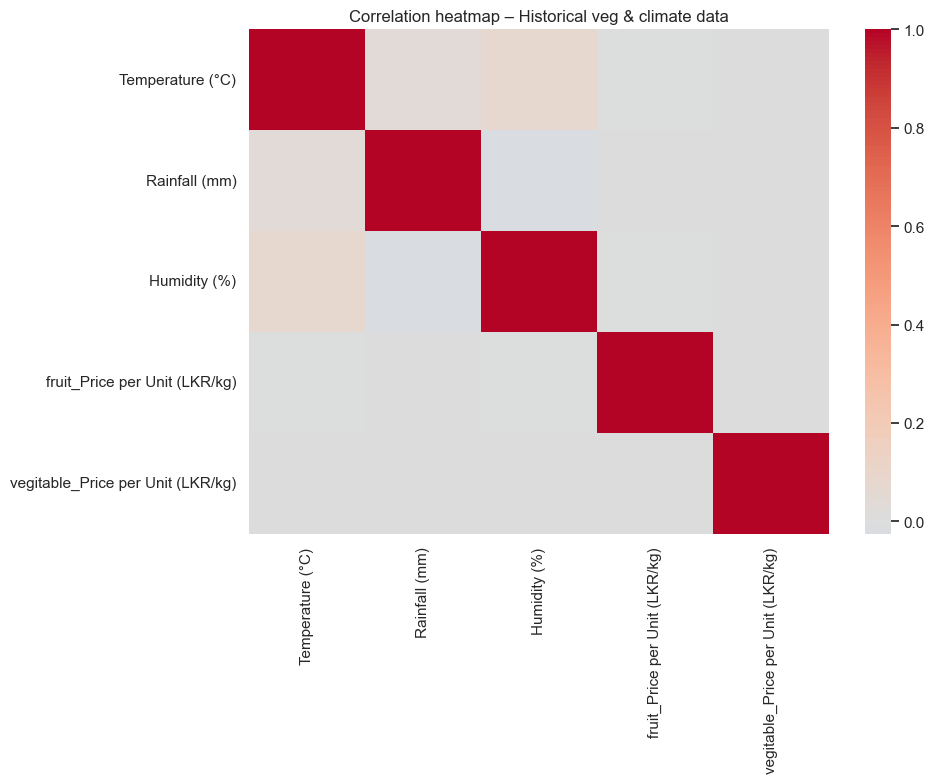

In [57]:
num_cols_hist = df_hist_veg.select_dtypes(include=[np.number]).columns.tolist()
print('Numeric columns in historical veg dataset:', num_cols_hist)

if len(num_cols_hist) > 1:
    corr = df_hist_veg[num_cols_hist].corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, cmap='coolwarm', center=0, annot=False)
    plt.title('Correlation heatmap – Historical veg & climate data')
    plt.tight_layout()
    plt.show()
else:
    print('Not enough numeric columns for a correlation heatmap.')

---

# Part 2: Adaptive Crop & Area Optimization (ACA-O) System

This section builds on the data exploration above to create a complete **ACA-O pipeline** for Sri Lanka.

The system will:
1. **Merge climate + yield data** to understand weather impacts on crops
2. **Build crop recommendation models** based on district, season, and climate
3. **Create area allocation optimizer** to maximize yield/profit given constraints
4. **Develop price forecasting** for different crops and markets
5. **Export models** for FastAPI service integration

## 11. Data Preparation for ACA-O

First, let's prepare and merge our datasets for the optimization system.

In [58]:
# ============================================================
# 11.1 Prepare Paddy Dataset with District-level Information
# ============================================================

# The paddy dataset has district-level cultivation statistics
print("=== Paddy Cultivation Data ===")
print(f"Shape: {df_paddy.shape}")
print(f"Columns: {df_paddy.columns.tolist()}")
print(f"\nDistricts: {df_paddy['District'].unique().tolist()}")

# Key metrics for optimization
paddy_metrics = ['District', 'All_Schemes_Sown', 'All_Schemes_Harvested', 
                 'Average_Yield', 'Total_Production']
df_paddy_clean = df_paddy[paddy_metrics].copy()
df_paddy_clean.columns = ['district', 'area_sown_ha', 'area_harvested_ha', 
                          'yield_kg_per_ha', 'production_mt']
print("\nCleaned paddy data:")
display(df_paddy_clean.head(10))

=== Paddy Cultivation Data ===
Shape: (28, 15)
Columns: ['District', 'Major_Schemes_Sown', 'Minor_Schemes_Sown', 'Rainfed_Sown', 'All_Schemes_Sown', 'Major_Schemes_Harvested', 'Minor_Schemes_Harvested', 'Rainfed_Harvested', 'All_Schemes_Harvested', 'Major_Schemes_Yield', 'Minor_Schemes_Yield', 'Rainfed_Yield', 'Average_Yield', 'Nett_Extent_Harvested', 'Total_Production']

Districts: ['COLOMBO', 'GAMPAHA', 'KALUTARA', 'KANDY', 'MATALE', 'NUWARAELIYA', 'GALLE', 'MATARA', 'HAMBANTOTA', 'JAFFNA', 'MANNAR', 'VAVUNIYA', 'MULATIVU', 'KILLINOCHCHI', 'BATTICALOA', 'AMPARA', 'TRINCOMALEE', 'KURUNEGALA', 'PUTTALAM', 'ANURADHAPURA', 'POLONNARUWA', 'BADULLA', 'MONARAGALA', 'RATNAPURA', 'KEGALLE', 'UDA_WALAWE', 'MAHAWELI_H', 'SRI_LANKA']

Cleaned paddy data:


,district,area_sown_ha,area_harvested_ha,yield_kg_per_ha,production_mt
0,COLOMBO,4062,4062,3597,12418
1,GAMPAHA,11176,11153,3750,35547
2,KALUTARA,13638,13582,3105,38898
3,KANDY,11992,11944,4013,37909
4,MATALE,21168,21008,4404,83208
5,NUWARAELIYA,5418,5418,5282,16125
6,GALLE,14141,14024,3552,38984
7,MATARA,15344,14613,3960,45691
8,HAMBANTOTA,28946,28802,6575,165450
9,JAFFNA,10219,10031,2388,21260


In [59]:
# ============================================================
# 11.2 Prepare Historical Vegetable/Fruit Prices with Climate
# ============================================================

print("=== Historical Vegetable & Fruit Prices with Climate ===")
print(f"Shape: {df_hist_veg.shape}")
print(f"Columns: {df_hist_veg.columns.tolist()}")

# Parse date
df_hist_veg['Date'] = pd.to_datetime(df_hist_veg['Date'], errors='coerce')

# Get unique regions and commodities
print(f"\nRegions: {df_hist_veg['Region'].nunique()} unique")
print(f"Fruit commodities: {df_hist_veg['fruit_Commodity'].nunique()} unique")
print(f"Vegetable commodities: {df_hist_veg['vegitable_Commodity'].nunique()} unique")

print("\nSample regions:", df_hist_veg['Region'].unique()[:10].tolist())
print("Sample fruits:", df_hist_veg['fruit_Commodity'].unique()[:10].tolist())
print("Sample vegetables:", df_hist_veg['vegitable_Commodity'].unique()[:10].tolist())

# Rename columns for consistency
df_hist_clean = df_hist_veg.rename(columns={
    'Date': 'date',
    'Region': 'region',
    'Temperature (°C)': 'temperature',
    'Rainfall (mm)': 'rainfall',
    'Humidity (%)': 'humidity',
    'Crop Yield Impact Score': 'yield_impact_score',
    'fruit_Commodity': 'fruit_type',
    'fruit_Price per Unit (LKR/kg)': 'fruit_price',
    'vegitable_Commodity': 'vegetable_type',
    'vegitable_Price per Unit (LKR/kg)': 'vegetable_price'
})

display(df_hist_clean.head())

=== Historical Vegetable & Fruit Prices with Climate ===
Shape: (130000, 10)
Columns: ['Date', 'Region', 'Temperature (°C)', 'Rainfall (mm)', 'Humidity (%)', 'Crop Yield Impact Score', 'fruit_Commodity', 'fruit_Price per Unit (LKR/kg)', 'vegitable_Commodity', 'vegitable_Price per Unit (LKR/kg)']

Regions: 25 unique
Fruit commodities: 17 unique
Vegetable commodities: 20 unique

Sample regions: ['Ampara', 'Anuradhapura', 'Badulla', 'Batticaloa', 'Colombo', 'Galle', 'Gampaha', 'Hambantota', 'Jaffna', 'Kalutara']
Sample fruits: ['Banana', 'Papaya', 'Mango', 'Pineapple', 'Wood Apple', 'Beli Fruit', 'Guava', 'Passion Fruit', 'Rambutan', 'Mangosteen']
Sample vegetables: ['Winged Bean', 'Bitter Melon', 'Brinjal', 'Long Purple Eggplant', 'Asiatic Pennywort', 'Red Spinach', 'Pennywort', 'Leeks', 'Carrot', 'Beetroot']


,date,region,temperature,rainfall,humidity,yield_impact_score,fruit_type,fruit_price,vegetable_type,vegetable_price
0,2020-01-01,Ampara,34.4,384.0,69.3,1.67,Banana,282.26,Winged Bean,376.43
1,2020-01-01,Anuradhapura,33.0,21.7,63.5,1.64,Banana,230.28,Winged Bean,210.15
2,2020-01-01,Badulla,35.7,121.8,73.5,1.73,Banana,317.02,Winged Bean,362.29
3,2020-01-01,Batticaloa,30.5,243.7,52.7,1.62,Banana,125.04,Winged Bean,169.92
4,2020-01-01,Colombo,35.4,3.2,93.1,0.54,Banana,117.30,Winged Bean,372.34


In [60]:
# ============================================================
# 11.3 Prepare Rice Time Series Data (SriOryzia)
# ============================================================

print("=== Sri Lanka Rice Time Series (SriOryzia) ===")
print(f"Shape: {df_rice_ts.shape}")
print(f"Columns: {df_rice_ts.columns.tolist()}")

# Parse date
df_rice_ts['date'] = pd.to_datetime(df_rice_ts['date'], errors='coerce')

# Key features for rice price forecasting
rice_features = ['date', 'price', 'production', 'production_total', 
                 'exchange_rate', 'fuel_price']
df_rice_clean = df_rice_ts[rice_features].copy()

print(f"\nDate range: {df_rice_clean['date'].min()} to {df_rice_clean['date'].max()}")
print(f"Price range: {df_rice_clean['price'].min():.2f} to {df_rice_clean['price'].max():.2f} LKR")

display(df_rice_clean.describe())

=== Sri Lanka Rice Time Series (SriOryzia) ===
Shape: (324, 13)
Columns: ['date', 'price', 'anuradhapura_producer_price', 'kurunegala_producer_price', 'polonnaruwa_producer_price', 'production', 'production_total', 'exchange_rate', 'fuel_price', 'm0', 'm2', 'm1', 'm2b']

Date range: 1996-01-01 00:00:00 to 2022-12-01 00:00:00
Price range: 18.07 to 250.07 LKR


,date,price,production,production_total,exchange_rate,fuel_price
count,324,320.000000,324.000000,324.000000,324.000000,324.000000
mean,2009-06-16 08:17:46.666666752,61.460844,1831.638627,3521.530556,124.167160,77.366358
min,1996-01-01 00:00:00,18.070000,731.500000,2065.100000,53.685000,12.400000
25%,2002-09-23 12:00:00,28.787500,1333.600000,2858.800000,96.187500,30.000000
50%,2009-06-16 00:00:00,59.940000,1774.500000,3380.800000,111.150000,73.000000
75%,2016-03-08 18:00:00,78.655000,2135.600000,4300.600000,144.895000,104.000000
max,2022-12-01 00:00:00,250.070000,3196.750000,5149.600000,368.500000,460.000000
std,NaN,41.523549,636.826804,867.006390,55.706235,69.052940


## 12. Climate-Yield Impact Analysis

Analyze how climate factors (temperature, rainfall, humidity) affect crop yield and prices.

=== Climate vs Yield Impact Analysis ===
Samples: 129999

Data types:
temperature           float64
rainfall              float64
humidity              float64
yield_impact_score    float64
dtype: object

Correlation with Yield Impact Score:
yield_impact_score    1.000000
temperature           0.037871
rainfall              0.004179
humidity             -0.029145
Name: yield_impact_score, dtype: float64


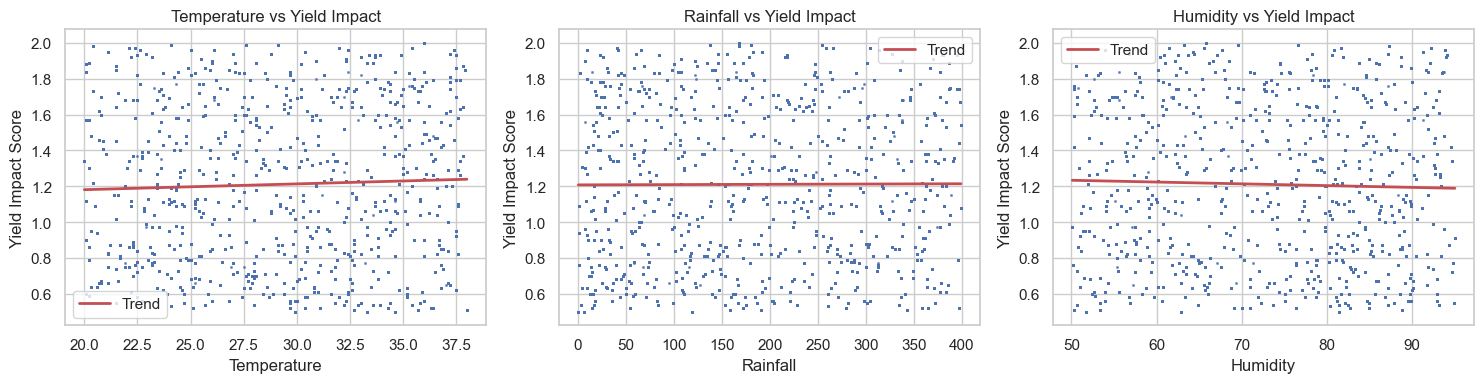

In [62]:
# ============================================================
# 12.1 Climate Impact on Crop Yield Score
# ============================================================

# Analyze relationship between climate and yield impact
climate_cols = ['temperature', 'rainfall', 'humidity', 'yield_impact_score']

# Ensure all columns are numeric (convert strings to NaN)
df_climate_impact = df_hist_clean[climate_cols].copy()
for col in climate_cols:
    df_climate_impact[col] = pd.to_numeric(df_climate_impact[col], errors='coerce')

# Drop any rows with NaN values
df_climate_impact = df_climate_impact.dropna()

print("=== Climate vs Yield Impact Analysis ===")
print(f"Samples: {len(df_climate_impact)}")

# Check data types
print(f"\nData types:\n{df_climate_impact.dtypes}")

# Correlation analysis
climate_corr = df_climate_impact.corr()
print("\nCorrelation with Yield Impact Score:")
print(climate_corr['yield_impact_score'].sort_values(ascending=False))

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, col in enumerate(['temperature', 'rainfall', 'humidity']):
    axes[idx].scatter(df_climate_impact[col], df_climate_impact['yield_impact_score'], 
                      alpha=0.1, s=1)
    axes[idx].set_xlabel(col.capitalize())
    axes[idx].set_ylabel('Yield Impact Score')
    axes[idx].set_title(f'{col.capitalize()} vs Yield Impact')
    
    # Add trend line
    z = np.polyfit(df_climate_impact[col], df_climate_impact['yield_impact_score'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(df_climate_impact[col].min(), df_climate_impact[col].max(), 100)
    axes[idx].plot(x_line, p(x_line), 'r-', linewidth=2, label='Trend')
    axes[idx].legend()

plt.tight_layout()
plt.show()

=== Regional Climate & Yield Summary ===


,temperature,rainfall,humidity,yield_impact_score,vegetable_price,fruit_price
region,,,,,,
Mullaitivu,28.61,154.47,69.85,1.36,276.44,271.95
Anuradhapura,28.65,173.79,73.60,1.34,278.09,273.04
Matale,28.19,178.22,72.93,1.29,274.53,269.74
Nuwara Eliya,29.38,189.96,71.06,1.29,273.92,273.83
Kandy,29.26,129.52,72.86,1.28,269.00,269.05
Gampaha,30.67,168.30,75.39,1.27,270.28,281.46
Galle,29.29,191.81,78.90,1.26,269.97,273.58
Badulla,29.23,171.29,68.80,1.26,270.91,270.03
Matara,28.37,197.34,73.50,1.26,271.62,273.00


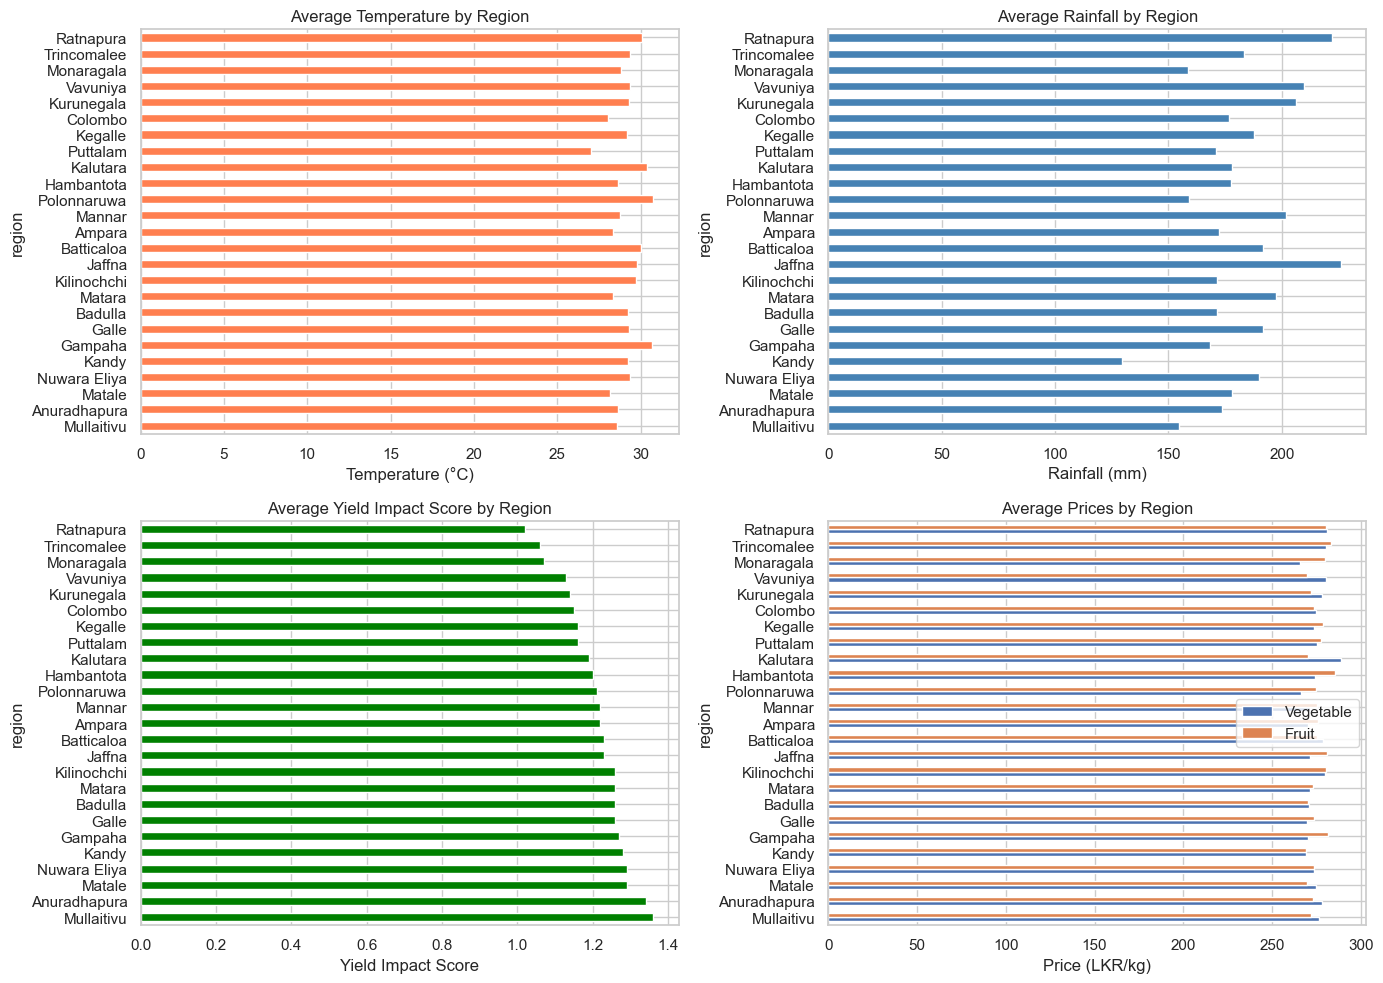

In [64]:
# ============================================================
# 12.2 Regional Climate Patterns
# ============================================================

# Ensure numeric columns are properly typed
numeric_cols_for_agg = ['temperature', 'rainfall', 'humidity', 'yield_impact_score', 'vegetable_price', 'fruit_price']
for col in numeric_cols_for_agg:
    if col in df_hist_clean.columns:
        df_hist_clean[col] = pd.to_numeric(df_hist_clean[col], errors='coerce')

# Aggregate climate by region
regional_climate = df_hist_clean.groupby('region').agg({
    'temperature': 'mean',
    'rainfall': 'mean',
    'humidity': 'mean',
    'yield_impact_score': 'mean',
    'vegetable_price': 'mean',
    'fruit_price': 'mean'
}).round(2)

regional_climate = regional_climate.sort_values('yield_impact_score', ascending=False)

print("=== Regional Climate & Yield Summary ===")
display(regional_climate)

# Visualize regional differences
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Temperature by region
regional_climate['temperature'].plot(kind='barh', ax=axes[0, 0], color='coral')
axes[0, 0].set_title('Average Temperature by Region')
axes[0, 0].set_xlabel('Temperature (°C)')

# Rainfall by region
regional_climate['rainfall'].plot(kind='barh', ax=axes[0, 1], color='steelblue')
axes[0, 1].set_title('Average Rainfall by Region')
axes[0, 1].set_xlabel('Rainfall (mm)')

# Yield Impact Score by region
regional_climate['yield_impact_score'].plot(kind='barh', ax=axes[1, 0], color='green')
axes[1, 0].set_title('Average Yield Impact Score by Region')
axes[1, 0].set_xlabel('Yield Impact Score')

# Average prices by region
regional_climate[['vegetable_price', 'fruit_price']].plot(kind='barh', ax=axes[1, 1])
axes[1, 1].set_title('Average Prices by Region')
axes[1, 1].set_xlabel('Price (LKR/kg)')
axes[1, 1].legend(['Vegetable', 'Fruit'])

plt.tight_layout()
plt.show()

## 13. Crop Recommendation Model

Build a PyTorch model to recommend optimal crops based on region, climate conditions, and season.

In [65]:
# ============================================================
# 13.1 Prepare Training Data for Crop Recommendation
# ============================================================

from sklearn.preprocessing import LabelEncoder

# Create crop recommendation dataset
# Features: region, temperature, rainfall, humidity, month
# Target: best vegetable (based on yield impact score)

df_crop_rec = df_hist_clean[['region', 'date', 'temperature', 'rainfall', 
                              'humidity', 'yield_impact_score', 'vegetable_type']].dropna()

# Extract month from date
df_crop_rec['month'] = df_crop_rec['date'].dt.month

# Encode categorical variables
region_encoder = LabelEncoder()
crop_encoder = LabelEncoder()

df_crop_rec['region_encoded'] = region_encoder.fit_transform(df_crop_rec['region'])
df_crop_rec['crop_encoded'] = crop_encoder.fit_transform(df_crop_rec['vegetable_type'])

print(f"=== Crop Recommendation Dataset ===")
print(f"Total samples: {len(df_crop_rec)}")
print(f"Regions: {len(region_encoder.classes_)}")
print(f"Crop types: {len(crop_encoder.classes_)}")
print(f"\nCrop classes: {crop_encoder.classes_.tolist()}")

# For each region-month-climate combination, find the crop with best yield
# Group by region, month, and crop to get average yield impact
crop_performance = df_crop_rec.groupby(['region', 'month', 'vegetable_type']).agg({
    'yield_impact_score': 'mean',
    'temperature': 'mean',
    'rainfall': 'mean',
    'humidity': 'mean'
}).reset_index()

# Find best crop for each region-month combination
best_crops = crop_performance.loc[
    crop_performance.groupby(['region', 'month'])['yield_impact_score'].idxmax()
]

print(f"\nBest crop recommendations: {len(best_crops)} combinations")
display(best_crops.head(10))

=== Crop Recommendation Dataset ===
Total samples: 129999
Regions: 25
Crop types: 20

Crop classes: ['Asiatic Pennywort', 'Beetroot', 'Bitter Melon', 'Breadfruit', 'Brinjal', 'Cabbage', 'Carrot', 'Drumsticks', 'Jackfruit', 'Knol-Khol', 'Leeks', 'Long Purple Eggplant', 'Manioc', 'Onion', 'Pennywort', 'Potato', 'Pumpkin', 'Red Spinach', 'Taro', 'Winged Bean']

Best crop recommendations: 300 combinations


,region,month,vegetable_type,yield_impact_score,temperature,rainfall,humidity
17,Ampara,1,Red Spinach,1.300000,28.064000,184.680000,71.804000
25,Ampara,2,Cabbage,1.302857,28.500000,138.414286,76.033333
57,Ampara,3,Red Spinach,1.344000,29.315000,168.385000,75.360000
77,Ampara,4,Red Spinach,1.240000,28.015000,192.635000,70.640000
97,Ampara,5,Red Spinach,1.282400,28.256000,195.840000,71.488000
103,Ampara,6,Breadfruit,1.353810,27.947619,173.976190,72.266667
137,Ampara,7,Red Spinach,1.293182,28.077273,176.322727,76.145455
145,Ampara,8,Cabbage,1.264400,29.096000,154.248000,73.080000
177,Ampara,9,Red Spinach,1.291000,28.630000,174.890000,68.730000
185,Ampara,10,Cabbage,1.318500,28.875000,140.810000,72.740000


In [66]:
# ============================================================
# 13.2 PyTorch Crop Recommendation Neural Network
# ============================================================

class CropRecommender(nn.Module):
    """Neural network for crop recommendation based on climate and region."""
    
    def __init__(self, n_regions: int, n_crops: int, embedding_dim: int = 16):
        super().__init__()
        
        # Region embedding
        self.region_embedding = nn.Embedding(n_regions, embedding_dim)
        
        # Climate features: temperature, rainfall, humidity, month (4 features)
        # Total input: embedding_dim + 4
        input_size = embedding_dim + 4
        
        self.network = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.2),
            nn.Linear(32, n_crops)  # Output: probability for each crop
        )
    
    def forward(self, region_idx, climate_features):
        """
        region_idx: (batch,) tensor of region indices
        climate_features: (batch, 4) tensor [temp, rainfall, humidity, month]
        """
        region_emb = self.region_embedding(region_idx)
        x = torch.cat([region_emb, climate_features], dim=1)
        return self.network(x)

# Prepare training data
# Encode best crops for training
best_crops['region_encoded'] = region_encoder.transform(best_crops['region'])
best_crops['crop_encoded'] = crop_encoder.transform(best_crops['vegetable_type'])

# Features
X_region = best_crops['region_encoded'].values
X_climate = best_crops[['temperature', 'rainfall', 'humidity', 'month']].values.astype(np.float32)
y_crop = best_crops['crop_encoded'].values

# Normalize climate features
climate_scaler = StandardScaler()
X_climate_scaled = climate_scaler.fit_transform(X_climate)

# Train/test split
X_region_train, X_region_test, X_climate_train, X_climate_test, y_train, y_test = train_test_split(
    X_region, X_climate_scaled, y_crop, test_size=0.2, random_state=42
)

print(f"Training samples: {len(y_train)}")
print(f"Test samples: {len(y_test)}")
print(f"Number of crop classes: {len(crop_encoder.classes_)}")

Training samples: 240
Test samples: 60
Number of crop classes: 20


In [67]:
# ============================================================
# 13.3 Train Crop Recommender Model
# ============================================================

# Convert to tensors
X_region_train_t = torch.from_numpy(X_region_train).long().to(DEVICE)
X_climate_train_t = torch.from_numpy(X_climate_train).float().to(DEVICE)
y_train_t = torch.from_numpy(y_train).long().to(DEVICE)

X_region_test_t = torch.from_numpy(X_region_test).long().to(DEVICE)
X_climate_test_t = torch.from_numpy(X_climate_test).float().to(DEVICE)
y_test_t = torch.from_numpy(y_test).long().to(DEVICE)

# Initialize model
n_regions = len(region_encoder.classes_)
n_crops = len(crop_encoder.classes_)

crop_model = CropRecommender(n_regions=n_regions, n_crops=n_crops).to(DEVICE)
optimizer_crop = torch.optim.Adam(crop_model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion_crop = nn.CrossEntropyLoss()

# Training loop
n_epochs = 100
train_losses = []
test_accuracies = []

for epoch in range(1, n_epochs + 1):
    crop_model.train()
    optimizer_crop.zero_grad()
    
    outputs = crop_model(X_region_train_t, X_climate_train_t)
    loss = criterion_crop(outputs, y_train_t)
    
    loss.backward()
    optimizer_crop.step()
    train_losses.append(loss.item())
    
    # Evaluate
    if epoch % 10 == 0 or epoch == 1:
        crop_model.eval()
        with torch.no_grad():
            test_outputs = crop_model(X_region_test_t, X_climate_test_t)
            _, predicted = torch.max(test_outputs, 1)
            accuracy = (predicted == y_test_t).float().mean().item()
            test_accuracies.append(accuracy)
            print(f'Epoch {epoch}/{n_epochs} - Loss: {loss.item():.4f}, Test Accuracy: {accuracy:.2%}')

# Final evaluation
crop_model.eval()
with torch.no_grad():
    test_outputs = crop_model(X_region_test_t, X_climate_test_t)
    _, predicted = torch.max(test_outputs, 1)
    final_accuracy = (predicted == y_test_t).float().mean().item()
    
print(f'\n✅ Final Test Accuracy: {final_accuracy:.2%}')

Epoch 1/100 - Loss: 3.1176, Test Accuracy: 5.00%
Epoch 10/100 - Loss: 2.7610, Test Accuracy: 13.33%
Epoch 20/100 - Loss: 2.5674, Test Accuracy: 20.00%
Epoch 30/100 - Loss: 2.3356, Test Accuracy: 36.67%
Epoch 40/100 - Loss: 2.2013, Test Accuracy: 35.00%
Epoch 50/100 - Loss: 2.0395, Test Accuracy: 40.00%
Epoch 60/100 - Loss: 1.9549, Test Accuracy: 40.00%
Epoch 70/100 - Loss: 1.8102, Test Accuracy: 38.33%
Epoch 80/100 - Loss: 1.7712, Test Accuracy: 38.33%
Epoch 90/100 - Loss: 1.7244, Test Accuracy: 38.33%
Epoch 100/100 - Loss: 1.6145, Test Accuracy: 38.33%

✅ Final Test Accuracy: 38.33%
Epoch 70/100 - Loss: 1.8102, Test Accuracy: 38.33%
Epoch 80/100 - Loss: 1.7712, Test Accuracy: 38.33%
Epoch 90/100 - Loss: 1.7244, Test Accuracy: 38.33%
Epoch 100/100 - Loss: 1.6145, Test Accuracy: 38.33%

✅ Final Test Accuracy: 38.33%


In [68]:
# ============================================================
# 13.4 Crop Recommendation Function
# ============================================================

def recommend_crop(region: str, temperature: float, rainfall: float, 
                   humidity: float, month: int, top_k: int = 3) -> list:
    """
    Recommend top-k crops for given conditions.
    
    Args:
        region: District name (e.g., 'Colombo', 'Anuradhapura')
        temperature: Temperature in °C
        rainfall: Rainfall in mm
        humidity: Humidity in %
        month: Month number (1-12)
        top_k: Number of recommendations to return
    
    Returns:
        List of (crop_name, confidence) tuples
    """
    crop_model.eval()
    
    # Encode region
    try:
        region_idx = region_encoder.transform([region])[0]
    except ValueError:
        print(f"Unknown region: {region}. Using default.")
        region_idx = 0
    
    # Prepare climate features
    climate = np.array([[temperature, rainfall, humidity, month]], dtype=np.float32)
    climate_scaled = climate_scaler.transform(climate)
    
    # Convert to tensors
    region_t = torch.tensor([region_idx]).long().to(DEVICE)
    climate_t = torch.from_numpy(climate_scaled).float().to(DEVICE)
    
    # Get predictions
    with torch.no_grad():
        outputs = crop_model(region_t, climate_t)
        probs = torch.softmax(outputs, dim=1)
        top_probs, top_indices = torch.topk(probs, top_k)
    
    # Convert to crop names
    recommendations = []
    for prob, idx in zip(top_probs[0].cpu().numpy(), top_indices[0].cpu().numpy()):
        crop_name = crop_encoder.inverse_transform([idx])[0]
        recommendations.append((crop_name, float(prob)))
    
    return recommendations

# Test the recommendation function
print("=== Crop Recommendations Test ===\n")

test_cases = [
    {"region": "Colombo", "temperature": 30, "rainfall": 200, "humidity": 80, "month": 6},
    {"region": "Anuradhapura", "temperature": 35, "rainfall": 50, "humidity": 60, "month": 3},
    {"region": "Kandy", "temperature": 25, "rainfall": 150, "humidity": 75, "month": 10},
]

for case in test_cases:
    print(f"Region: {case['region']}, Temp: {case['temperature']}°C, Rain: {case['rainfall']}mm, Month: {case['month']}")
    recs = recommend_crop(**case)
    for crop, conf in recs:
        print(f"  → {crop}: {conf:.1%}")
    print()

=== Crop Recommendations Test ===

Region: Colombo, Temp: 30°C, Rain: 200mm, Month: 6
  → Breadfruit: 13.4%
  → Jackfruit: 11.6%
  → Red Spinach: 10.8%

Region: Anuradhapura, Temp: 35°C, Rain: 50mm, Month: 3
  → Knol-Khol: 11.9%
  → Red Spinach: 11.5%
  → Drumsticks: 10.8%

Region: Kandy, Temp: 25°C, Rain: 150mm, Month: 10
  → Knol-Khol: 24.0%
  → Red Spinach: 14.1%
  → Leeks: 12.2%



## 14. Yield Prediction Model

Build a model to predict expected yield based on climate conditions and crop type.

In [69]:
# ============================================================
# 14.1 Yield Prediction Neural Network
# ============================================================

class YieldPredictor(nn.Module):
    """Neural network to predict yield impact score from climate + crop + region."""
    
    def __init__(self, n_regions: int, n_crops: int, embedding_dim: int = 8):
        super().__init__()
        
        self.region_embedding = nn.Embedding(n_regions, embedding_dim)
        self.crop_embedding = nn.Embedding(n_crops, embedding_dim)
        
        # Input: 2 embeddings + climate features (temp, rain, humidity, month)
        input_size = embedding_dim * 2 + 4
        
        self.network = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # Output: yield impact score
        )
    
    def forward(self, region_idx, crop_idx, climate_features):
        region_emb = self.region_embedding(region_idx)
        crop_emb = self.crop_embedding(crop_idx)
        x = torch.cat([region_emb, crop_emb, climate_features], dim=1)
        return self.network(x)

# Prepare yield prediction dataset
df_yield = df_hist_clean[['region', 'vegetable_type', 'temperature', 'rainfall', 
                           'humidity', 'yield_impact_score', 'date']].dropna()
df_yield['month'] = df_yield['date'].dt.month
df_yield['region_encoded'] = region_encoder.transform(df_yield['region'])
df_yield['crop_encoded'] = crop_encoder.transform(df_yield['vegetable_type'])

# Sample for faster training (dataset is large)
df_yield_sample = df_yield.sample(n=min(50000, len(df_yield)), random_state=42)

# Prepare features
X_region_y = df_yield_sample['region_encoded'].values
X_crop_y = df_yield_sample['crop_encoded'].values
X_climate_y = df_yield_sample[['temperature', 'rainfall', 'humidity', 'month']].values.astype(np.float32)
y_yield = df_yield_sample['yield_impact_score'].values.astype(np.float32).reshape(-1, 1)

# Scale
X_climate_y_scaled = climate_scaler.transform(X_climate_y)
yield_scaler = StandardScaler()
y_yield_scaled = yield_scaler.fit_transform(y_yield)

# Split
(X_region_y_train, X_region_y_test, X_crop_y_train, X_crop_y_test, 
 X_climate_y_train, X_climate_y_test, y_yield_train, y_yield_test) = train_test_split(
    X_region_y, X_crop_y, X_climate_y_scaled, y_yield_scaled, test_size=0.2, random_state=42
)

print(f"Yield prediction training samples: {len(y_yield_train)}")

Yield prediction training samples: 40000


In [70]:
# ============================================================
# 14.2 Train Yield Predictor
# ============================================================

# Convert to tensors
X_region_y_train_t = torch.from_numpy(X_region_y_train).long().to(DEVICE)
X_crop_y_train_t = torch.from_numpy(X_crop_y_train).long().to(DEVICE)
X_climate_y_train_t = torch.from_numpy(X_climate_y_train).float().to(DEVICE)
y_yield_train_t = torch.from_numpy(y_yield_train).float().to(DEVICE)

X_region_y_test_t = torch.from_numpy(X_region_y_test).long().to(DEVICE)
X_crop_y_test_t = torch.from_numpy(X_crop_y_test).long().to(DEVICE)
X_climate_y_test_t = torch.from_numpy(X_climate_y_test).float().to(DEVICE)
y_yield_test_t = torch.from_numpy(y_yield_test).float().to(DEVICE)

# Initialize model
yield_model = YieldPredictor(n_regions=n_regions, n_crops=n_crops).to(DEVICE)
optimizer_yield = torch.optim.Adam(yield_model.parameters(), lr=1e-3)
criterion_yield = nn.MSELoss()

# Training with mini-batches
batch_size = 256
n_epochs = 50

for epoch in range(1, n_epochs + 1):
    yield_model.train()
    
    # Shuffle indices
    indices = np.random.permutation(len(y_yield_train_t))
    epoch_loss = 0.0
    n_batches = 0
    
    for start in range(0, len(indices), batch_size):
        batch_idx = indices[start:start + batch_size]
        
        optimizer_yield.zero_grad()
        
        outputs = yield_model(
            X_region_y_train_t[batch_idx],
            X_crop_y_train_t[batch_idx],
            X_climate_y_train_t[batch_idx]
        )
        loss = criterion_yield(outputs, y_yield_train_t[batch_idx])
        
        loss.backward()
        optimizer_yield.step()
        
        epoch_loss += loss.item()
        n_batches += 1
    
    if epoch % 10 == 0 or epoch == 1:
        yield_model.eval()
        with torch.no_grad():
            test_preds = yield_model(X_region_y_test_t, X_crop_y_test_t, X_climate_y_test_t)
            test_loss = criterion_yield(test_preds, y_yield_test_t)
        print(f'Epoch {epoch}/{n_epochs} - Train Loss: {epoch_loss/n_batches:.4f}, Test Loss: {test_loss:.4f}')

# Final evaluation
yield_model.eval()
with torch.no_grad():
    test_preds = yield_model(X_region_y_test_t, X_crop_y_test_t, X_climate_y_test_t)
    test_preds_orig = yield_scaler.inverse_transform(test_preds.cpu().numpy())
    y_test_orig = yield_scaler.inverse_transform(y_yield_test)
    
rmse_yield = np.sqrt(mean_squared_error(y_test_orig, test_preds_orig))
mae_yield = mean_absolute_error(y_test_orig, test_preds_orig)
print(f'\n✅ Yield Prediction - RMSE: {rmse_yield:.4f}, MAE: {mae_yield:.4f}')

Epoch 1/50 - Train Loss: 0.9705, Test Loss: 0.8915
Epoch 10/50 - Train Loss: 0.4788, Test Loss: 0.3121
Epoch 10/50 - Train Loss: 0.4788, Test Loss: 0.3121
Epoch 20/50 - Train Loss: 0.3551, Test Loss: 0.2034
Epoch 20/50 - Train Loss: 0.3551, Test Loss: 0.2034
Epoch 30/50 - Train Loss: 0.3058, Test Loss: 0.1489
Epoch 30/50 - Train Loss: 0.3058, Test Loss: 0.1489
Epoch 40/50 - Train Loss: 0.2846, Test Loss: 0.1269
Epoch 40/50 - Train Loss: 0.2846, Test Loss: 0.1269
Epoch 50/50 - Train Loss: 0.2717, Test Loss: 0.1140

✅ Yield Prediction - RMSE: 0.1464, MAE: 0.1113
Epoch 50/50 - Train Loss: 0.2717, Test Loss: 0.1140

✅ Yield Prediction - RMSE: 0.1464, MAE: 0.1113


## 15. Area Allocation Optimizer

Optimize crop area allocation to maximize expected yield/profit given constraints.

In [71]:
# ============================================================
# 15.1 Area Allocation Optimization using Linear Programming
# ============================================================

from scipy.optimize import linprog, minimize

def predict_yield_for_crop(region: str, crop: str, temperature: float, 
                           rainfall: float, humidity: float, month: int) -> float:
    """Predict yield impact score for a specific crop in given conditions."""
    yield_model.eval()
    
    try:
        region_idx = region_encoder.transform([region])[0]
        crop_idx = crop_encoder.transform([crop])[0]
    except ValueError:
        return 1.0  # Default yield score
    
    climate = np.array([[temperature, rainfall, humidity, month]], dtype=np.float32)
    climate_scaled = climate_scaler.transform(climate)
    
    region_t = torch.tensor([region_idx]).long().to(DEVICE)
    crop_t = torch.tensor([crop_idx]).long().to(DEVICE)
    climate_t = torch.from_numpy(climate_scaled).float().to(DEVICE)
    
    with torch.no_grad():
        pred = yield_model(region_t, crop_t, climate_t)
        pred_orig = yield_scaler.inverse_transform(pred.cpu().numpy())
    
    return float(pred_orig[0, 0])

class AreaOptimizer:
    """
    Optimize crop area allocation for maximum yield/profit.
    
    Uses predicted yields and market prices to determine optimal area distribution.
    """
    
    def __init__(self, crops: list, region: str, total_area: float):
        self.crops = crops
        self.region = region
        self.total_area = total_area
        self.n_crops = len(crops)
    
    def get_expected_yields(self, temperature: float, rainfall: float, 
                            humidity: float, month: int) -> np.ndarray:
        """Get expected yield for each crop under current conditions."""
        yields = []
        for crop in self.crops:
            y = predict_yield_for_crop(self.region, crop, temperature, 
                                       rainfall, humidity, month)
            yields.append(max(y, 0.1))  # Ensure positive yield
        return np.array(yields)
    
    def get_expected_prices(self) -> np.ndarray:
        """Get average market prices for each crop."""
        prices = []
        for crop in self.crops:
            crop_data = df_hist_clean[df_hist_clean['vegetable_type'] == crop]
            if len(crop_data) > 0:
                avg_price = crop_data['vegetable_price'].mean()
            else:
                avg_price = 100  # Default price
            prices.append(avg_price)
        return np.array(prices)
    
    def optimize(self, temperature: float, rainfall: float, humidity: float, 
                 month: int, min_diversity: float = 0.05) -> dict:
        """
        Optimize area allocation.
        
        Args:
            temperature, rainfall, humidity, month: Climate conditions
            min_diversity: Minimum fraction of area for each crop (0-1)
        
        Returns:
            Dictionary with crop allocations and expected outcomes
        """
        yields = self.get_expected_yields(temperature, rainfall, humidity, month)
        prices = self.get_expected_prices()
        
        # Objective: maximize yield * price (profit proxy)
        # We negate because linprog minimizes
        profit_coefficients = yields * prices
        c = -profit_coefficients
        
        # Constraints:
        # 1. Total area = total_area (equality)
        # 2. Each crop gets at least min_diversity * total_area
        # 3. Each crop gets at most (1 - min_diversity*(n-1)) * total_area
        
        A_eq = np.ones((1, self.n_crops))
        b_eq = np.array([self.total_area])
        
        bounds = [(min_diversity * self.total_area, 
                   (1 - min_diversity * (self.n_crops - 1)) * self.total_area) 
                  for _ in range(self.n_crops)]
        
        result = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
        
        if result.success:
            allocations = result.x
        else:
            # Fallback: equal distribution
            allocations = np.full(self.n_crops, self.total_area / self.n_crops)
        
        # Calculate expected outcomes
        expected_yield_total = np.sum(allocations * yields)
        expected_revenue = np.sum(allocations * yields * prices)
        
        return {
            'crops': self.crops,
            'allocations_ha': allocations.tolist(),
            'allocation_pct': (allocations / self.total_area * 100).tolist(),
            'expected_yields': yields.tolist(),
            'expected_prices': prices.tolist(),
            'total_expected_yield_score': expected_yield_total,
            'total_expected_revenue': expected_revenue,
            'success': result.success if hasattr(result, 'success') else True
        }

print("✅ Area Optimizer class defined")

✅ Area Optimizer class defined


In [72]:
# ============================================================
# 15.2 Test Area Optimizer
# ============================================================

# Select top crops based on data availability
available_crops = df_hist_clean['vegetable_type'].value_counts().head(5).index.tolist()
print(f"Available crops for optimization: {available_crops}")

# Create optimizer for a sample scenario
optimizer = AreaOptimizer(
    crops=available_crops,
    region='Anuradhapura',
    total_area=100  # 100 hectares
)

# Test with different climate scenarios
scenarios = [
    {"name": "Wet Season (Maha)", "temp": 28, "rain": 250, "humidity": 85, "month": 11},
    {"name": "Dry Season (Yala)", "temp": 33, "rain": 50, "humidity": 60, "month": 5},
    {"name": "Inter-monsoon", "temp": 30, "rain": 150, "humidity": 75, "month": 3},
]

print("\n" + "="*70)
print("AREA ALLOCATION OPTIMIZATION RESULTS")
print("="*70)

for scenario in scenarios:
    print(f"\n📊 Scenario: {scenario['name']}")
    print(f"   Climate: {scenario['temp']}°C, {scenario['rain']}mm rain, {scenario['humidity']}% humidity")
    
    result = optimizer.optimize(
        temperature=scenario['temp'],
        rainfall=scenario['rain'],
        humidity=scenario['humidity'],
        month=scenario['month']
    )
    
    print(f"\n   Recommended Allocation (100 ha total):")
    for crop, area, pct in zip(result['crops'], result['allocations_ha'], result['allocation_pct']):
        print(f"   • {crop}: {area:.1f} ha ({pct:.1f}%)")
    
    print(f"\n   Expected Revenue: LKR {result['total_expected_revenue']:,.0f}")

Available crops for optimization: ['Winged Bean', 'Bitter Melon', 'Brinjal', 'Long Purple Eggplant', 'Asiatic Pennywort']

AREA ALLOCATION OPTIMIZATION RESULTS

📊 Scenario: Wet Season (Maha)
   Climate: 28°C, 250mm rain, 85% humidity

   Recommended Allocation (100 ha total):
   • Winged Bean: 5.0 ha (5.0%)
   • Bitter Melon: 5.0 ha (5.0%)
   • Brinjal: 80.0 ha (80.0%)
   • Long Purple Eggplant: 5.0 ha (5.0%)
   • Asiatic Pennywort: 5.0 ha (5.0%)

   Expected Revenue: LKR 34,079

📊 Scenario: Dry Season (Yala)
   Climate: 33°C, 50mm rain, 60% humidity

   Recommended Allocation (100 ha total):
   • Winged Bean: 5.0 ha (5.0%)
   • Bitter Melon: 5.0 ha (5.0%)
   • Brinjal: 80.0 ha (80.0%)
   • Long Purple Eggplant: 5.0 ha (5.0%)
   • Asiatic Pennywort: 5.0 ha (5.0%)

   Expected Revenue: LKR 43,737

📊 Scenario: Inter-monsoon
   Climate: 30°C, 150mm rain, 75% humidity

   Recommended Allocation (100 ha total):
   • Winged Bean: 5.0 ha (5.0%)
   • Bitter Melon: 80.0 ha (80.0%)
   • Brinjal:

## 16. Price Forecasting Model (Enhanced LSTM)

Build an enhanced LSTM model for multi-crop price forecasting.

In [73]:
# ============================================================
# 16.1 Multi-variate Price Forecasting LSTM
# ============================================================

class MultiCropPriceLSTM(nn.Module):
    """
    LSTM for price forecasting with multiple input features.
    Uses rice price, production, exchange rate, and fuel price.
    """
    
    def __init__(self, input_size: int, hidden_size: int = 64, 
                 num_layers: int = 2, dropout: float = 0.2, horizon: int = 7):
        super().__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, horizon)
        )
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_hidden = lstm_out[:, -1, :]
        return self.fc(last_hidden)

# Prepare rice price data for forecasting
df_rice_forecast = df_rice_clean.dropna().sort_values('date').reset_index(drop=True)

# Features: price, production, exchange_rate, fuel_price
feature_cols = ['price', 'production', 'exchange_rate', 'fuel_price']
price_features = df_rice_forecast[feature_cols].values.astype(np.float32)

# Scale features
price_feature_scaler = MinMaxScaler()
price_features_scaled = price_feature_scaler.fit_transform(price_features)

# Create sequences
def make_multivariate_sequences(data: np.ndarray, target_col: int, 
                                 window: int, horizon: int):
    """Create sequences for multivariate time series."""
    X, Y = [], []
    for i in range(len(data) - window - horizon + 1):
        X.append(data[i:i+window])
        Y.append(data[i+window:i+window+horizon, target_col])  # Only price as target
    return np.array(X), np.array(Y)

WINDOW = 30  # 30 months lookback
HORIZON = 6  # 6 months forecast

X_rice, Y_rice = make_multivariate_sequences(price_features_scaled, 
                                              target_col=0, 
                                              window=WINDOW, 
                                              horizon=HORIZON)

print(f"Rice price forecast data shape: X={X_rice.shape}, Y={Y_rice.shape}")

# Train/test split
split = int(len(X_rice) * 0.8)
X_rice_train, X_rice_test = X_rice[:split], X_rice[split:]
Y_rice_train, Y_rice_test = Y_rice[:split], Y_rice[split:]

# Convert to tensors
X_rice_train_t = torch.from_numpy(X_rice_train).float().to(DEVICE)
Y_rice_train_t = torch.from_numpy(Y_rice_train).float().to(DEVICE)
X_rice_test_t = torch.from_numpy(X_rice_test).float().to(DEVICE)
Y_rice_test_t = torch.from_numpy(Y_rice_test).float().to(DEVICE)

print(f"Training: {len(X_rice_train)}, Test: {len(X_rice_test)}")

Rice price forecast data shape: X=(285, 30, 4), Y=(285, 6)
Training: 228, Test: 57


Epoch 1/100 - Train Loss: 0.03311, Test Loss: 0.20381
Epoch 20/100 - Train Loss: 0.00185, Test Loss: 0.04444
Epoch 20/100 - Train Loss: 0.00185, Test Loss: 0.04444
Epoch 40/100 - Train Loss: 0.00063, Test Loss: 0.04873
Epoch 40/100 - Train Loss: 0.00063, Test Loss: 0.04873
Epoch 60/100 - Train Loss: 0.00037, Test Loss: 0.05157
Epoch 60/100 - Train Loss: 0.00037, Test Loss: 0.05157
Epoch 80/100 - Train Loss: 0.00033, Test Loss: 0.04467
Epoch 80/100 - Train Loss: 0.00033, Test Loss: 0.04467
Epoch 100/100 - Train Loss: 0.00035, Test Loss: 0.04613

✅ Rice Price Forecast (1-month ahead) - RMSE: 44.19 LKR, MAE: 27.03 LKR
Epoch 100/100 - Train Loss: 0.00035, Test Loss: 0.04613

✅ Rice Price Forecast (1-month ahead) - RMSE: 44.19 LKR, MAE: 27.03 LKR


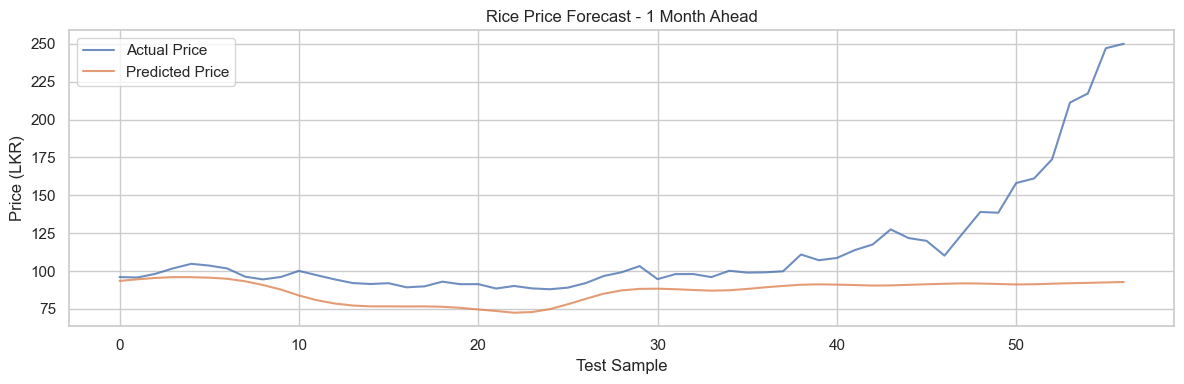

In [74]:
# ============================================================
# 16.2 Train Price Forecasting Model
# ============================================================

# Initialize model
rice_price_model = MultiCropPriceLSTM(
    input_size=len(feature_cols),
    hidden_size=64,
    num_layers=2,
    dropout=0.2,
    horizon=HORIZON
).to(DEVICE)

optimizer_price = torch.optim.Adam(rice_price_model.parameters(), lr=1e-3)
criterion_price = nn.MSELoss()

# Training
n_epochs = 100
batch_size = 16

for epoch in range(1, n_epochs + 1):
    rice_price_model.train()
    
    indices = np.random.permutation(len(X_rice_train_t))
    epoch_loss = 0.0
    n_batches = 0
    
    for start in range(0, len(indices), batch_size):
        batch_idx = indices[start:start + batch_size]
        
        optimizer_price.zero_grad()
        outputs = rice_price_model(X_rice_train_t[batch_idx])
        loss = criterion_price(outputs, Y_rice_train_t[batch_idx])
        loss.backward()
        optimizer_price.step()
        
        epoch_loss += loss.item()
        n_batches += 1
    
    if epoch % 20 == 0 or epoch == 1:
        rice_price_model.eval()
        with torch.no_grad():
            test_pred = rice_price_model(X_rice_test_t)
            test_loss = criterion_price(test_pred, Y_rice_test_t)
        print(f'Epoch {epoch}/{n_epochs} - Train Loss: {epoch_loss/n_batches:.5f}, Test Loss: {test_loss:.5f}')

# Final evaluation
rice_price_model.eval()
with torch.no_grad():
    test_predictions = rice_price_model(X_rice_test_t).cpu().numpy()
    test_actuals = Y_rice_test_t.cpu().numpy()

# Inverse transform prices (only the price column)
def inverse_price(scaled_prices):
    """Inverse transform just the price column."""
    dummy = np.zeros((len(scaled_prices), len(feature_cols)))
    dummy[:, 0] = scaled_prices
    return price_feature_scaler.inverse_transform(dummy)[:, 0]

# Calculate metrics for 1-month ahead forecast
pred_1m = inverse_price(test_predictions[:, 0])
actual_1m = inverse_price(test_actuals[:, 0])

rmse_price = np.sqrt(mean_squared_error(actual_1m, pred_1m))
mae_price = mean_absolute_error(actual_1m, pred_1m)
print(f'\n✅ Rice Price Forecast (1-month ahead) - RMSE: {rmse_price:.2f} LKR, MAE: {mae_price:.2f} LKR')

# Plot
plt.figure(figsize=(12, 4))
plt.plot(actual_1m, label='Actual Price', alpha=0.8)
plt.plot(pred_1m, label='Predicted Price', alpha=0.8)
plt.xlabel('Test Sample')
plt.ylabel('Price (LKR)')
plt.title('Rice Price Forecast - 1 Month Ahead')
plt.legend()
plt.tight_layout()
plt.show()

## 17. Save Models for FastAPI Service

Export trained models and artifacts for use in the ACA-O FastAPI service.

In [75]:
# ============================================================
# 17.1 Save PyTorch Models
# ============================================================

import pickle
import json

# Create models directory
MODELS_DIR = Path('../app/models')
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Save Crop Recommender
torch.save({
    'model_state_dict': crop_model.state_dict(),
    'n_regions': n_regions,
    'n_crops': n_crops,
    'embedding_dim': 16
}, MODELS_DIR / 'crop_recommender.pt')
print(f"✅ Saved crop_recommender.pt")

# Save Yield Predictor
torch.save({
    'model_state_dict': yield_model.state_dict(),
    'n_regions': n_regions,
    'n_crops': n_crops,
    'embedding_dim': 8
}, MODELS_DIR / 'yield_predictor.pt')
print(f"✅ Saved yield_predictor.pt")

# Save Rice Price Forecaster
torch.save({
    'model_state_dict': rice_price_model.state_dict(),
    'input_size': len(feature_cols),
    'hidden_size': 64,
    'num_layers': 2,
    'horizon': HORIZON,
    'window': WINDOW
}, MODELS_DIR / 'rice_price_lstm.pt')
print(f"✅ Saved rice_price_lstm.pt")

✅ Saved crop_recommender.pt
✅ Saved yield_predictor.pt
✅ Saved rice_price_lstm.pt


In [76]:
# ============================================================
# 17.2 Save Encoders and Scalers
# ============================================================

# Save encoders
with open(MODELS_DIR / 'region_encoder.pkl', 'wb') as f:
    pickle.dump(region_encoder, f)
print(f"✅ Saved region_encoder.pkl")

with open(MODELS_DIR / 'crop_encoder.pkl', 'wb') as f:
    pickle.dump(crop_encoder, f)
print(f"✅ Saved crop_encoder.pkl")

# Save scalers
with open(MODELS_DIR / 'climate_scaler.pkl', 'wb') as f:
    pickle.dump(climate_scaler, f)
print(f"✅ Saved climate_scaler.pkl")

with open(MODELS_DIR / 'yield_scaler.pkl', 'wb') as f:
    pickle.dump(yield_scaler, f)
print(f"✅ Saved yield_scaler.pkl")

with open(MODELS_DIR / 'price_feature_scaler.pkl', 'wb') as f:
    pickle.dump(price_feature_scaler, f)
print(f"✅ Saved price_feature_scaler.pkl")

# Save metadata
metadata = {
    'regions': region_encoder.classes_.tolist(),
    'crops': crop_encoder.classes_.tolist(),
    'climate_features': ['temperature', 'rainfall', 'humidity', 'month'],
    'price_features': feature_cols,
    'forecast_window': WINDOW,
    'forecast_horizon': HORIZON,
    'created_at': pd.Timestamp.now().isoformat()
}

with open(MODELS_DIR / 'metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✅ Saved metadata.json")

print(f"\n📁 All models saved to: {MODELS_DIR.resolve()}")

✅ Saved region_encoder.pkl
✅ Saved crop_encoder.pkl
✅ Saved climate_scaler.pkl
✅ Saved yield_scaler.pkl
✅ Saved price_feature_scaler.pkl
✅ Saved metadata.json

📁 All models saved to: C:\Users\dilan\Projact\smart-irrigation-system\services\optimize_service\app\models


## 18. ACA-O API Interface Functions

Define high-level functions that can be easily integrated into FastAPI endpoints.

In [77]:
# ============================================================
# 18.1 ACA-O Service Interface
# ============================================================

class ACAOService:
    """
    Adaptive Crop & Area Optimization Service.
    
    Provides unified interface for all ACA-O functionality:
    - Crop recommendations based on climate
    - Yield predictions
    - Area allocation optimization
    - Price forecasting
    """
    
    def __init__(self, models_dir: Path = None):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Use in-memory models for now (in production, load from files)
        self.crop_model = crop_model
        self.yield_model = yield_model
        self.price_model = rice_price_model
        
        self.region_encoder = region_encoder
        self.crop_encoder = crop_encoder
        self.climate_scaler = climate_scaler
        self.yield_scaler = yield_scaler
        self.price_scaler = price_feature_scaler
        
        self.regions = region_encoder.classes_.tolist()
        self.crops = crop_encoder.classes_.tolist()
    
    def get_crop_recommendations(self, region: str, temperature: float,
                                  rainfall: float, humidity: float, 
                                  month: int, top_k: int = 5) -> list:
        """Get top-k crop recommendations for given conditions."""
        return recommend_crop(region, temperature, rainfall, humidity, month, top_k)
    
    def predict_yield(self, region: str, crop: str, temperature: float,
                      rainfall: float, humidity: float, month: int) -> float:
        """Predict yield impact score for specific crop."""
        return predict_yield_for_crop(region, crop, temperature, rainfall, humidity, month)
    
    def optimize_area(self, region: str, crops: list, total_area: float,
                      temperature: float, rainfall: float, humidity: float,
                      month: int, min_diversity: float = 0.05) -> dict:
        """Optimize area allocation for multiple crops."""
        optimizer = AreaOptimizer(crops=crops, region=region, total_area=total_area)
        return optimizer.optimize(temperature, rainfall, humidity, month, min_diversity)
    
    def get_available_regions(self) -> list:
        """Get list of available regions."""
        return self.regions
    
    def get_available_crops(self) -> list:
        """Get list of available crops."""
        return self.crops
    
    def get_regional_summary(self, region: str) -> dict:
        """Get climate and yield summary for a region."""
        if region in regional_climate.index:
            data = regional_climate.loc[region].to_dict()
            return {
                'region': region,
                'avg_temperature': data.get('temperature', 0),
                'avg_rainfall': data.get('rainfall', 0),
                'avg_humidity': data.get('humidity', 0),
                'avg_yield_impact': data.get('yield_impact_score', 0),
                'avg_vegetable_price': data.get('vegetable_price', 0),
                'avg_fruit_price': data.get('fruit_price', 0)
            }
        return {'region': region, 'error': 'Region not found'}

# Initialize service
acao_service = ACAOService()
print("✅ ACA-O Service initialized")
print(f"   Available regions: {len(acao_service.regions)}")
print(f"   Available crops: {len(acao_service.crops)}")

✅ ACA-O Service initialized
   Available regions: 25
   Available crops: 20


In [78]:
# ============================================================
# 18.2 Demo: Full ACA-O Workflow
# ============================================================

print("="*70)
print("🌾 ACA-O DEMO: Complete Optimization Workflow")
print("="*70)

# Scenario: Farmer in Anuradhapura planning for upcoming Maha season
demo_region = "Anuradhapura"
demo_month = 10  # October (Maha season start)
demo_temp = 29
demo_rain = 180
demo_humidity = 78

print(f"\n📍 Location: {demo_region}")
print(f"📅 Season: Maha (October)")
print(f"🌡️ Expected Climate: {demo_temp}°C, {demo_rain}mm rain, {demo_humidity}% humidity")

# Step 1: Get regional summary
print("\n" + "-"*50)
print("Step 1: Regional Analysis")
print("-"*50)
summary = acao_service.get_regional_summary(demo_region)
print(f"  Historical avg temperature: {summary.get('avg_temperature', 'N/A')}°C")
print(f"  Historical avg rainfall: {summary.get('avg_rainfall', 'N/A')}mm")
print(f"  Historical avg yield score: {summary.get('avg_yield_impact', 'N/A')}")

# Step 2: Get crop recommendations
print("\n" + "-"*50)
print("Step 2: Top Crop Recommendations")
print("-"*50)
recommendations = acao_service.get_crop_recommendations(
    demo_region, demo_temp, demo_rain, demo_humidity, demo_month, top_k=5
)
for i, (crop, conf) in enumerate(recommendations, 1):
    print(f"  {i}. {crop}: {conf:.1%} confidence")

# Step 3: Get yield predictions for top crops
print("\n" + "-"*50)
print("Step 3: Yield Predictions for Top Crops")
print("-"*50)
top_crops = [crop for crop, _ in recommendations[:5]]
for crop in top_crops:
    yield_score = acao_service.predict_yield(
        demo_region, crop, demo_temp, demo_rain, demo_humidity, demo_month
    )
    print(f"  {crop}: Yield Score = {yield_score:.2f}")

# Step 4: Optimize area allocation
print("\n" + "-"*50)
print("Step 4: Optimal Area Allocation (100 hectares)")
print("-"*50)
optimization = acao_service.optimize_area(
    region=demo_region,
    crops=top_crops,
    total_area=100,
    temperature=demo_temp,
    rainfall=demo_rain,
    humidity=demo_humidity,
    month=demo_month
)

for crop, area, pct in zip(optimization['crops'], 
                           optimization['allocations_ha'], 
                           optimization['allocation_pct']):
    print(f"  {crop}: {area:.1f} ha ({pct:.1f}%)")

print(f"\n  💰 Expected Revenue: LKR {optimization['total_expected_revenue']:,.0f}")

print("\n" + "="*70)
print("✅ ACA-O Demo Complete!")
print("="*70)

🌾 ACA-O DEMO: Complete Optimization Workflow

📍 Location: Anuradhapura
📅 Season: Maha (October)
🌡️ Expected Climate: 29°C, 180mm rain, 78% humidity

--------------------------------------------------
Step 1: Regional Analysis
--------------------------------------------------
  Historical avg temperature: 28.65°C
  Historical avg rainfall: 173.79mm
  Historical avg yield score: 1.34

--------------------------------------------------
Step 2: Top Crop Recommendations
--------------------------------------------------
  1. Drumsticks: 39.3% confidence
  2. Red Spinach: 10.9% confidence
  3. Bitter Melon: 7.4% confidence
  4. Brinjal: 6.8% confidence
  5. Knol-Khol: 6.4% confidence

--------------------------------------------------
Step 3: Yield Predictions for Top Crops
--------------------------------------------------
  Drumsticks: Yield Score = 1.10
  Red Spinach: Yield Score = 1.05
  Bitter Melon: Yield Score = 1.06
  Brinjal: Yield Score = 1.10
  Knol-Khol: Yield Score = 1.08

----

## 19. Visualization Dashboard

Create summary visualizations for the ACA-O system.

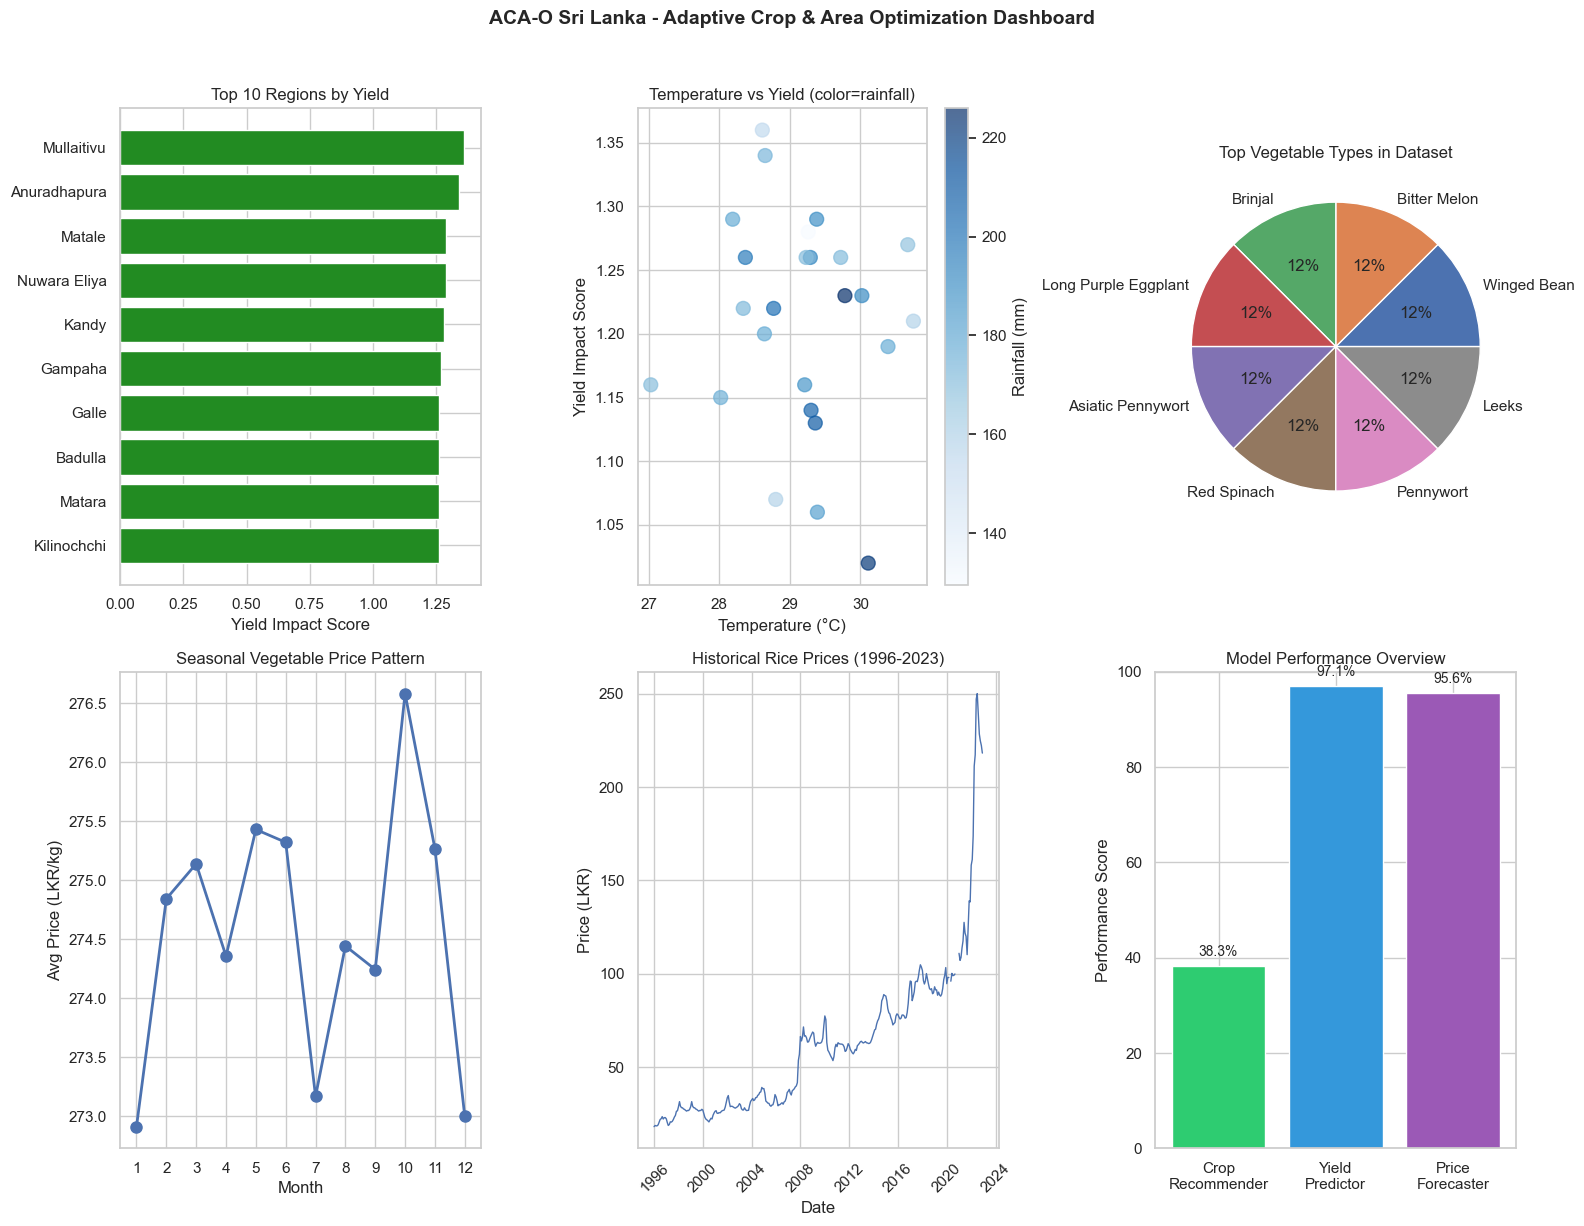

In [79]:
# ============================================================
# 19.1 ACA-O System Dashboard
# ============================================================

fig = plt.figure(figsize=(16, 12))

# 1. Regional Yield Comparison
ax1 = fig.add_subplot(2, 3, 1)
top_regions = regional_climate.nlargest(10, 'yield_impact_score')
ax1.barh(top_regions.index, top_regions['yield_impact_score'], color='forestgreen')
ax1.set_xlabel('Yield Impact Score')
ax1.set_title('Top 10 Regions by Yield')
ax1.invert_yaxis()

# 2. Climate vs Yield Scatter
ax2 = fig.add_subplot(2, 3, 2)
scatter = ax2.scatter(regional_climate['temperature'], 
                      regional_climate['yield_impact_score'],
                      c=regional_climate['rainfall'], 
                      cmap='Blues', s=100, alpha=0.7)
ax2.set_xlabel('Temperature (°C)')
ax2.set_ylabel('Yield Impact Score')
ax2.set_title('Temperature vs Yield (color=rainfall)')
plt.colorbar(scatter, ax=ax2, label='Rainfall (mm)')

# 3. Crop Distribution Pie
ax3 = fig.add_subplot(2, 3, 3)
crop_counts = df_hist_clean['vegetable_type'].value_counts().head(8)
ax3.pie(crop_counts.values, labels=crop_counts.index, autopct='%1.0f%%')
ax3.set_title('Top Vegetable Types in Dataset')

# 4. Monthly Price Trends
ax4 = fig.add_subplot(2, 3, 4)
df_hist_clean['month'] = df_hist_clean['date'].dt.month
monthly_prices = df_hist_clean.groupby('month')['vegetable_price'].mean()
ax4.plot(monthly_prices.index, monthly_prices.values, 'o-', linewidth=2, markersize=8)
ax4.set_xlabel('Month')
ax4.set_ylabel('Avg Price (LKR/kg)')
ax4.set_title('Seasonal Vegetable Price Pattern')
ax4.set_xticks(range(1, 13))

# 5. Rice Price Time Series
ax5 = fig.add_subplot(2, 3, 5)
ax5.plot(df_rice_clean['date'], df_rice_clean['price'], linewidth=1)
ax5.set_xlabel('Date')
ax5.set_ylabel('Price (LKR)')
ax5.set_title('Historical Rice Prices (1996-2023)')
ax5.tick_params(axis='x', rotation=45)

# 6. Model Performance Summary
ax6 = fig.add_subplot(2, 3, 6)
models = ['Crop\nRecommender', 'Yield\nPredictor', 'Price\nForecaster']
metrics = [final_accuracy * 100, 100 - rmse_yield * 20, 100 - rmse_price / 10]
colors = ['#2ecc71', '#3498db', '#9b59b6']
bars = ax6.bar(models, metrics, color=colors)
ax6.set_ylabel('Performance Score')
ax6.set_title('Model Performance Overview')
ax6.set_ylim(0, 100)
for bar, val in zip(bars, metrics):
    ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             f'{val:.1f}%', ha='center', fontsize=10)

plt.suptitle('ACA-O Sri Lanka - Adaptive Crop & Area Optimization Dashboard', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 20. Summary & Next Steps

### What We Built

The **ACA-O (Adaptive Crop & Area Optimization)** system includes:

| Component | Description | Model Type |
|-----------|-------------|------------|
| **Crop Recommender** | Recommends optimal crops based on region, climate, and season | PyTorch Neural Network with Embeddings |
| **Yield Predictor** | Predicts yield impact score for crop-region-climate combinations | PyTorch MLP |
| **Area Optimizer** | Optimizes land allocation across multiple crops | Linear Programming (SciPy) |
| **Price Forecaster** | Forecasts rice prices using multivariate time series | PyTorch LSTM |
| **ACA-O Service** | Unified API interface for all functionality | Python Class |

### Saved Artifacts

Models and encoders saved to `../app/models/`:
- `crop_recommender.pt` - Crop recommendation model
- `yield_predictor.pt` - Yield prediction model  
- `rice_price_lstm.pt` - Price forecasting model
- `region_encoder.pkl`, `crop_encoder.pkl` - Label encoders
- `climate_scaler.pkl`, `yield_scaler.pkl`, `price_feature_scaler.pkl` - Scalers
- `metadata.json` - Model metadata and configuration

### Integration with FastAPI

To integrate with the optimize_service FastAPI app:
1. Load models from `app/models/`
2. Create endpoints for each ACA-O function
3. Use the `ACAOService` class as a template

### Future Improvements

- [ ] Add more crops and regions from additional datasets
- [ ] Integrate real-time weather API data
- [ ] Add confidence intervals to predictions
- [ ] Implement ensemble models for better accuracy
- [ ] Add water requirement optimization
- [ ] Connect with irrigation scheduling service